**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1RaiYPz-2sS-EReNQL7tW6ms8ZuZphJLS?usp=sharing)

2. [Практика 1](https://colab.research.google.com/drive/1rd5i7URs1v_P8-KveFGFAQJ9thayJk1c?usp=sharing)

3. [Практика 2](https://colab.research.google.com/drive/1CSKLkE5eg6Y05o2pQigXH1wgZ0xqbXAw?usp=sharing)

4. Практика 3

#Обработка аудиосигналов: Классификация музыкальных жанров
## (полный набор признаков)

Это последний практический блок в данном уроке. Он отличается от предыдущего в двух аспектах:

* В функции `get_features()` по каждому файлу не вычисляется среднее значение по каждому признаку, а возвращается полный их набор. В результате из каждого аудиофайла генерируется не вектор признаков **(1, 37)**, а целая матрица **(1292, 37)**. Таким образом, объем входных данных увеличивается многократно.
* В функциях `create_train_classifier()`, `create_train_small_classifier()`, `compile_train()` изменены значения по умолчанию в отношении количества эпох обучения и размера батча. Это сделано для адаптации к возросшему объему данных на входе модели.

В остальном код идентичен коду предыдущего практического ноутбука; повторные объяснения здесь не приводятся.

Сравните подходы к решению задачи и полученные результаты.

##Импорт библиотек

In [ ]:
# Массивы
import numpy as np

# Отрисовка графиков
import matplotlib.pyplot as plt

# Связь с google диском
from google.colab import drive

# Загрузка из google облака
import gdown

# Преобразование категориальных данных в one hot encoding
from tensorflow.keras.utils import to_categorical

# Работа с папками и файлами
import os

# Утилиты работы со временем
import time

# Работа со случайными числами
import random

# Математические функции
import math

# Сохранение и загрузка структур данных Python
import pickle

# Параметризация аудио
import librosa

# Оптимизаторы для обучения моделей
from tensorflow.keras.optimizers import Adam, RMSprop

# Конструирование и загрузка моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model, load_model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

# Разбиение на обучающую и проверочную выборку
from sklearn.model_selection import train_test_split

# Кодирование категориальных меток, нормирование числовых данных
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

##Загрузка датасета и подготовка данных

In [ ]:
# Загрузка датасета из облака
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l12/genres.zip', None, quiet=False)

Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l12/genres.zip
To: /content/genres.zip
100%|██████████| 1.23G/1.23G [00:57<00:00, 21.2MB/s]


'genres.zip'

In [ ]:
# Распаковка архива на локальный диск colab
!unzip -qo genres.zip

# Проверка выгруженных папок
!ls genres 

# Проверка содержимого одной папки
!ls genres/blues

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
blues.00012.au	blues.00032.a

In [ ]:
# Установка констант

FILE_DIR = './genres'                     # Папка с файлами датасета
CLASS_LIST = os.listdir(FILE_DIR)         # Список классов, порядок меток не определен!
CLASS_LIST.sort()                         # Сортировка списка классов для фиксации порядка меток
CLASS_COUNT = len(CLASS_LIST)             # Количество классов
CLASS_FILES = 100                         # Общее количество файлов в каждом классе
FILE_INDEX_TRAIN_SPLIT = 90               # Количество файлов каждого класса на основной набор
VALIDATION_SPLIT = 0.1                    # Доля проверочной выборки в основном наборе
DURATION_SEC = 30                         # Анализируемая длительность аудиосигнала
N_FFT = 8192                              # Размер окна преобразования Фурье для расчета спектра
HOP_LENGTH = 512                          # Объем данных для расчета одного набора признаков

In [ ]:
# Проверка списка классов
print(CLASS_LIST)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [ ]:
# Функция параметризации аудио

def get_features(y,                     # волновое представление сигнала
                 sr,                    # частота дискретизации сигнала y
                 n_fft=N_FFT,           # размер скользящего окна БПФ
                 hop_length=HOP_LENGTH  # шаг скользящего окна БПФ
                 ):
    # Вычисление различных параметров (признаков) аудио

    # Хромаграмма
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Мел-кепстральные коэффициенты
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Среднеквадратическая амплитуда
    rmse = librosa.feature.rms(y=y, hop_length=hop_length)
    # Спектральный центроид
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Ширина полосы частот
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Спектральный спад частоты
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Пересечения нуля
    zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)
    
    # Сборка признаков в общий список:
    # На один файл несколько векторов признаков, количество определяется
    # продолжительностью аудио и параметром hop_length в функциях расчета признаков
    features = {'rmse': rmse, 
                'spct': spec_cent, 
                'spbw': spec_bw,
                'roff': rolloff,
                'zcr' : zcr,
                'mfcc': mfcc,
                'stft': chroma_stft}

    return features

In [ ]:
# Функция объединения признаков в набор векторов

def stack_features(feat  # словарь признаков, отдельные векторы по ключу каждого признака
                   ):
    features = None
    for v in feat.values():
        features = np.vstack((features, v)) if features is not None else v

    return features.T

In [ ]:
# Проверка параметризации одного произведения
y, sr = librosa.load(f'{FILE_DIR}/blues/blues.00000.au', mono=True, duration=DURATION_SEC)
features = get_features(y, sr)

In [ ]:
print({k: v.shape for k, v in features.items()})

{'rmse': (1, 1292), 'spct': (1, 1292), 'spbw': (1, 1292), 'roff': (1, 1292), 'zcr': (1, 1292), 'mfcc': (20, 1292), 'stft': (12, 1292)}


In [ ]:
# Проверка формирования набора признаков
feature_set = stack_features(features)
feature_set.shape

(1292, 37)

In [ ]:
# Функция формирования набора признаков и метки класса для аудиофайла

def get_feature_list_from_file(class_index,  # индекс класса файла song_name
                               song_name,    # имя аудиофайла
                               duration_sec  # длительность аудио в секундах
                               ):
    # Загрузка в y первых duration_sec секунд аудиосигнала
    y, sr = librosa.load(song_name, mono=True, duration=duration_sec)

    # Извлечение параметров из аудиосигнала
    features = get_features(y, sr)
    feature_set = stack_features(features)

    # Перевод номера класса в one hot encoding
    y_label = to_categorical(class_index, CLASS_COUNT)

    return feature_set, y_label

In [ ]:
# Функция формирования подвыборки признаков и меток класса для одного файла

def process_file(class_index,  # индекс класса аудиофайла
                 file_index,   # индекс (порядковый номер) аудиофайла в папке класса
                 duration_sec  # длительность аудио в секундах
                 ):
    x_list = []
    y_list = []
    class_name = CLASS_LIST[class_index]

    # Извлечение имени произведения
    song_name = f'{FILE_DIR}/{class_name}/{class_name}.{str(file_index).zfill(5)}.au'

    # Выборка признаков и метки класса для произведения
    feature_set, y_label = get_feature_list_from_file(class_index, 
                                                        song_name,
                                                        duration_sec)

    # Добавление данных в наборы
    for j in range(feature_set.shape[0]):
        x_list.append(feature_set[j])
        y_list.append(y_label)

    # Возврат имени файла и numpy-массивов призанков и меток класса
    return song_name, \
           np.array(x_list).astype('float32'), \
           np.array(y_list).astype('float32')

In [ ]:
# Функция формирования набора данных из файлов всех классов по диапазону номеров файлов

def extract_data(file_index_start,          # начальный индекс аудиофайла
                 file_index_end,            # конечный индекс аудиофайла (не достигая)
                 duration_sec=DURATION_SEC  # длительность аудио в секундах
                 ):

    # Списки для последовательностей входных данных и меток класса
    x_data = None
    y_data = None

    # Фиксация времени старта формирования выборки
    curr_time = time.time()

    # Для всех классов:
    for class_index in range(len(CLASS_LIST)):
        # Для всех файлов текущего класса из заданного диапазона номеров:
        for file_index in range(file_index_start, file_index_end):
            # Обработка одного файла и добавление данных к общим массивам
            _, file_x_data, file_y_data = process_file(class_index, file_index, duration_sec)
            x_data = file_x_data if x_data is None else np.vstack([x_data, file_x_data])
            y_data = file_y_data if y_data is None else np.vstack([y_data, file_y_data])

        # Вывод информации о готовности обработки датасета
        print(f'Жанр {CLASS_LIST[class_index]} готов -> {round(time.time() - curr_time)} c')
        curr_time = time.time()

    # Возврат массивов набора данных
    return x_data, y_data

In [ ]:
# Формирование тренировочного (основного) набора данных
x_train_data, y_train_data = extract_data(0, FILE_INDEX_TRAIN_SPLIT)

Жанр blues готов -> 163 c
Жанр classical готов -> 164 c
Жанр country готов -> 160 c
Жанр disco готов -> 158 c
Жанр hiphop готов -> 160 c
Жанр jazz готов -> 158 c
Жанр metal готов -> 161 c
Жанр pop готов -> 160 c
Жанр reggae готов -> 158 c
Жанр rock готов -> 162 c


In [ ]:
# Сохранение/восстановление датасета аудио
# Данные привязаны к порядку следования меток классов!
# Порядок классов фиксирован сортировкой списка меток классов
with open('/content/audio_data.pickle', 'wb') as f:
    pickle.dump((x_train_data, y_train_data), f)

with open('/content/audio_data.pickle', 'rb') as f:
    x_train_data, y_train_data = pickle.load(f)

In [ ]:
# Вывод номеров классов для проверки правильности заполнения
# Номера классов идут последовательно крупными блоками
print(np.argmax(y_train_data, axis=1))

[0 0 0 ... 9 9 9]


In [ ]:
# Вывод формы данных обучающего набора
print(x_train_data.shape, x_train_data.dtype)
print(y_train_data.shape, y_train_data.dtype)

(1162798, 37) float32
(1162798, 10) float32


In [ ]:
# Нормирование признаков в соответствии со стандартным нормальным распределением
x_scaler = StandardScaler()
x_train_data_scaled = x_scaler.fit_transform(x_train_data)

In [ ]:
# Разделение набора данных на обучающую и проверочную выборки
# Параметр stratify указывает метки классов, по которым происходит балансировка разделения
x_train, x_val, y_train, y_val = train_test_split(x_train_data_scaled,
                                                  y_train_data,
                                                  stratify=y_train_data,
                                                  test_size=VALIDATION_SPLIT)

In [ ]:
# Проверка нормирования
print(x_train[0])

[ 0.40899098 -0.1237544  -0.74904    -0.5251585   0.31842503  0.71436554
  0.22320016 -1.6746504   1.246737   -0.17945564  0.42408812 -1.1053855
  0.23248659 -1.8186754   0.6534638  -0.66311675 -0.6336639  -1.375822
  0.13981266 -1.0760435  -0.02994298 -0.81102264 -0.43107885 -0.04298083
 -0.05815024  2.0866754   0.16344702  1.1940362   0.43988934  1.0652082
 -0.23641822  0.7771125   0.3210078  -0.24529792 -0.3910217  -0.45490626
  1.7821833 ]


In [ ]:
# Проверка формы и типа данных обучающей и проверочной выборок
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print()
print(x_val.shape, x_val.dtype)
print(y_val.shape, y_val.dtype)

(1046518, 37) float32
(1046518, 10) float32

(116280, 37) float32
(116280, 10) float32


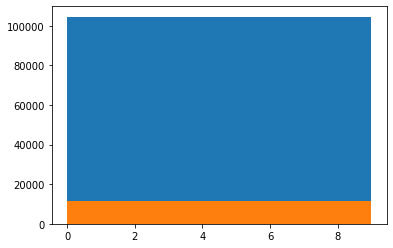

In [ ]:
# Проверка сбалансированности выборок по классам
plt.hist(np.argmax(y_train, axis=1), CLASS_COUNT)
plt.hist(np.argmax(y_val, axis=1), CLASS_COUNT)
plt.show()

##Модель нейронной сети

In [ ]:
# Функция сборки и обучения классификатора на полносвязных слоях

def create_train_classifier(in_shape,       # форма входных данных модели
                            epochs=50,      # количество эпох обучения
                            batch_size=512  # размер батча
                            ):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=in_shape))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(CLASS_COUNT, activation='softmax'))

    # Компиляция модели
    model.compile(optimizer=Adam(lr=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model.summary()

    # Обучение модели
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графика точности распознавания на обучающей и проверочной выборках
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
    plt.plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
    plt.xticks(range(epochs))
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()

    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               9728      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8

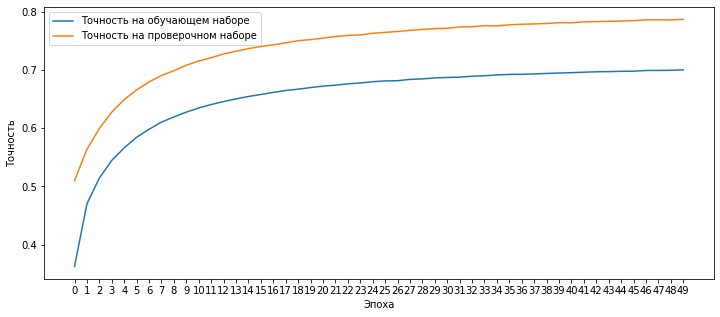

In [ ]:
model = create_train_classifier(x_train.shape[1:])

In [ ]:
# Сохранение/восстановление модели и выборок
model.save('/content/model_audio.h5')
with open('/content/audio_train_val.pickle', 'wb') as f:
    pickle.dump((x_train, y_train, x_val, y_val, x_scaler), f)

model = load_model('/content/model_audio.h5')
with open('/content/audio_train_val.pickle', 'rb') as f:
    x_train, y_train, x_val, y_val, x_scaler = pickle.load(f)

##Проверка точности предсказаний модели

###Проверка на данных тестовой выборки

In [ ]:
# Формирование тестовой выборки из файлов, не вошедших в основной набор
x_test, y_test = extract_data(FILE_INDEX_TRAIN_SPLIT, CLASS_FILES)
x_test = x_scaler.transform(x_test)

Жанр blues готов -> 18 c
Жанр classical готов -> 18 c
Жанр country готов -> 18 c
Жанр disco готов -> 18 c
Жанр hiphop готов -> 18 c
Жанр jazz готов -> 18 c
Жанр metal готов -> 18 c
Жанр pop готов -> 18 c
Жанр reggae готов -> 18 c
Жанр rock готов -> 18 c


In [ ]:
# Функция оценки точности модели на заданной выборке

def eval_model(model,  # обученная модель нейронной сети
               x,      # входные данные
               y_true  # выходные данные (верные ответы)
               ):
    loss, acc = model.evaluate(x, y_true)
    print(f'Ошибка: {loss}, точность: {acc}')

    # Построение матрицы ошибок
    y_pred = model.predict(x)
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Матрица ошибок нормализованная')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
    disp.plot(ax=ax)
    plt.show()    

3634/3634 [==============================] - 11s 3ms/step - loss: 0.6293 - accuracy: 0.7870
Ошибка: 0.6293120384216309, точность: 0.7869710922241211


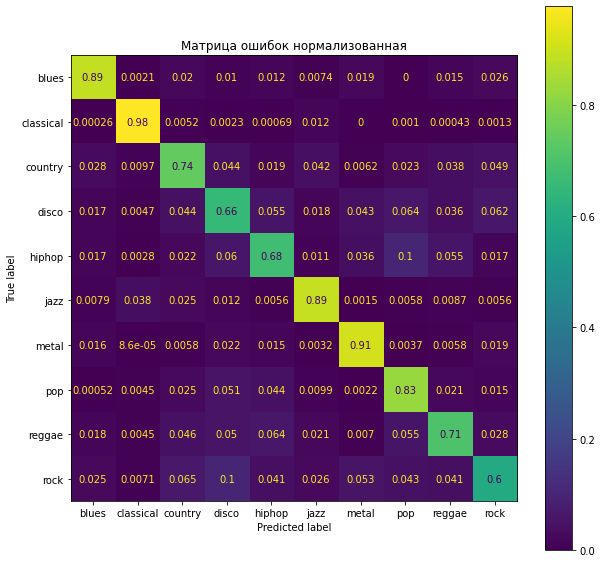

In [ ]:
# Оценка точности сети на проверочной выборке
eval_model(model, x_val, y_val)

4038/4038 [==============================] - 13s 3ms/step - loss: 1.5990 - accuracy: 0.4816
Ошибка: 1.5989954471588135, точность: 0.48163312673568726


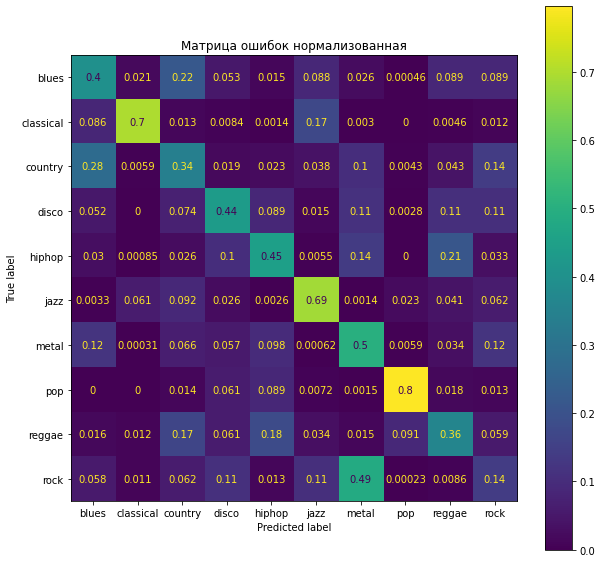

In [ ]:
# Оценка точности сети на тестовой выборке
eval_model(model, x_test, y_test)

###С прикладной точки зрения более верно проверять точность на звуковых файлах

In [ ]:
# Классификация файла и визуализация предсказания модели для него

def classify_file(model,        # обученная модель классификатора
                  x_scaler,     # настроенный нормировщих входных данных
                  class_index,  # верный индекс класса аудиофайла
                  file_index    # индекс (порядковый номер) аудиофайла в папке
                  ):
    # Подготовка выборки данных файла произведения
    song_name, file_x_data, file_y_data = process_file(class_index, file_index, DURATION_SEC)
    # Нормирование признаков уже настроенным нормировщиком
    file_x_data = x_scaler.transform(file_x_data)

    print('Файл:', song_name)
    print('Векторы для предсказания:', file_x_data.shape)

    # Вычисление предсказания по выборке
    predict = model.predict(file_x_data)
    # Определение среднего предсказания (голосование)
    predict_mean = predict.mean(axis=0)
    # Определение индекса класса по результату голосования
    predict_class_index = np.argmax(predict_mean)
    # Вычисление признака правильного предсказания
    predict_good = predict_class_index == class_index

    # Визуализация предсказания сети для файла
    plt.figure(figsize=(10,3))
    print('Классификация сети:', CLASS_LIST[predict_class_index], '-', 'ВЕРНО :-)' if predict_good else 'НЕВЕРНО.')
    plt.title('Среднее распределение векторов предсказаний')
    plt.bar(CLASS_LIST, predict_mean, color='g' if predict_good else 'r')
    plt.show()
    print('---------------------------------------------------------------')

    # Возврат результата предсказания
    return predict_class_index

In [ ]:
# Классификация и визуализация нескольких файлов каждого класса 

def classify_test_files(model,       # обученная модель классификатора
                        x_scaler,    # настроенный нормировщих входных данных
                        from_index,  # индекс аудиофайла, с которого начинать визуализацию
                        n_files):    # количество файлов для визуализации
    predict_all = 0
    predict_good = 0
    y_true = []
    y_pred = []
    for class_index in range(CLASS_COUNT):
        for file_index in range(from_index, from_index + n_files):
            predict_class_index = classify_file(model, x_scaler, class_index, file_index)
            y_true.append(class_index)
            y_pred.append(predict_class_index)
            predict_all += 1
            predict_good += (predict_class_index == class_index)

    # Расчет и вывод итогов классификации
    good_ratio = round(predict_good / predict_all * 100., 2)
    print(f'=== Обработано образцов: {predict_all}, из них распознано верно: {predict_good}, доля верных: {good_ratio}% ===')   

    # Построение матрицы ошибок без нормализации, покажет попадания в штуках
    cm = confusion_matrix(y_true, y_pred)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Матрица ошибок по файлам аудио (не нормализованная)')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
    disp.plot(ax=ax)
    plt.show()

###Визуализация на файлах тренировочного набора

Файл: ./genres/blues/blues.00050.au
Векторы для предсказания: (1292, 37)
Классификация сети: blues - ВЕРНО :-)


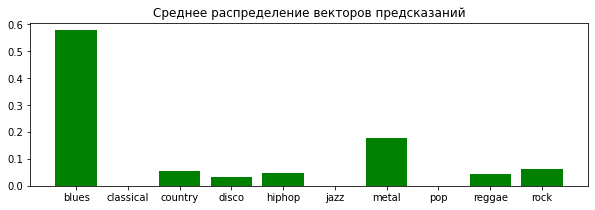

---------------------------------------------------------------
Файл: ./genres/blues/blues.00051.au
Векторы для предсказания: (1292, 37)
Классификация сети: blues - ВЕРНО :-)


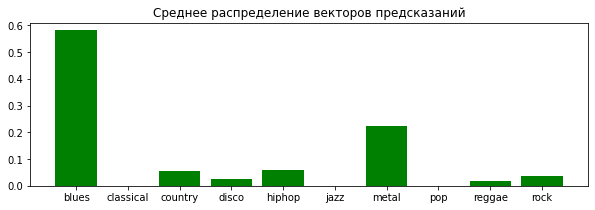

---------------------------------------------------------------
Файл: ./genres/blues/blues.00052.au
Векторы для предсказания: (1292, 37)
Классификация сети: blues - ВЕРНО :-)


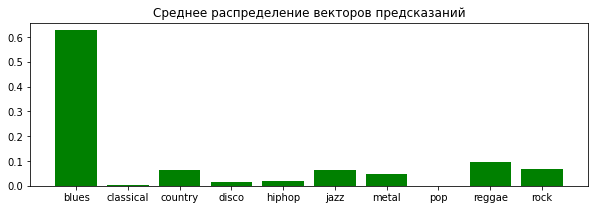

---------------------------------------------------------------
Файл: ./genres/blues/blues.00053.au
Векторы для предсказания: (1292, 37)
Классификация сети: blues - ВЕРНО :-)


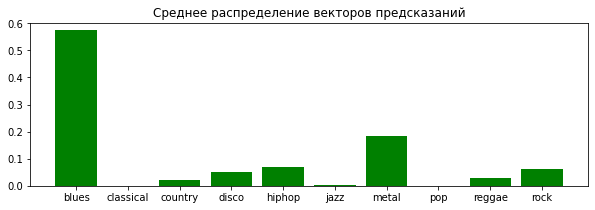

---------------------------------------------------------------
Файл: ./genres/blues/blues.00054.au
Векторы для предсказания: (1292, 37)
Классификация сети: blues - ВЕРНО :-)


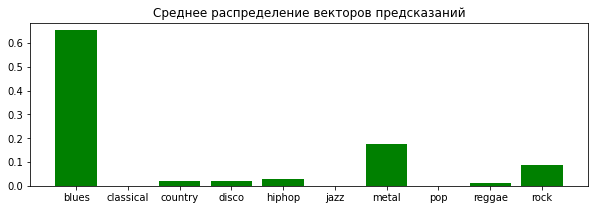

---------------------------------------------------------------
Файл: ./genres/classical/classical.00050.au
Векторы для предсказания: (1292, 37)
Классификация сети: classical - ВЕРНО :-)


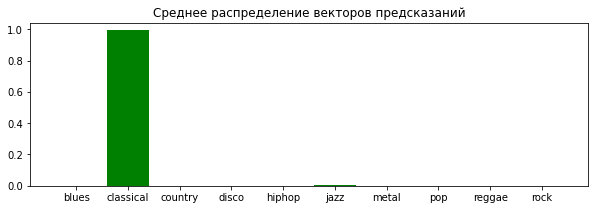

---------------------------------------------------------------
Файл: ./genres/classical/classical.00051.au
Векторы для предсказания: (1292, 37)
Классификация сети: classical - ВЕРНО :-)


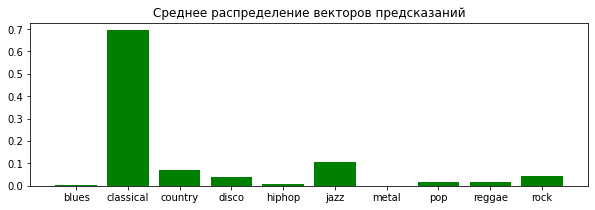

---------------------------------------------------------------
Файл: ./genres/classical/classical.00052.au
Векторы для предсказания: (1292, 37)
Классификация сети: classical - ВЕРНО :-)


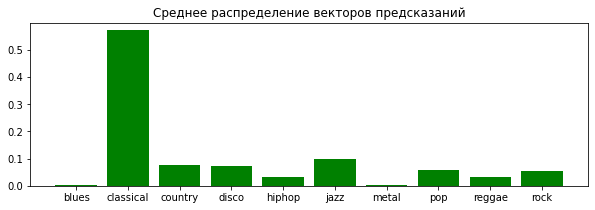

---------------------------------------------------------------
Файл: ./genres/classical/classical.00053.au
Векторы для предсказания: (1292, 37)
Классификация сети: classical - ВЕРНО :-)


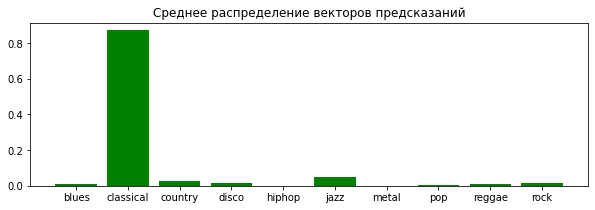

---------------------------------------------------------------
Файл: ./genres/classical/classical.00054.au
Векторы для предсказания: (1292, 37)
Классификация сети: classical - ВЕРНО :-)


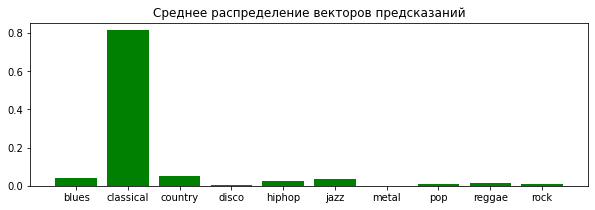

---------------------------------------------------------------
Файл: ./genres/country/country.00050.au
Векторы для предсказания: (1292, 37)
Классификация сети: country - ВЕРНО :-)


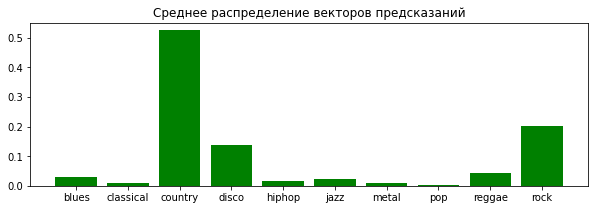

---------------------------------------------------------------
Файл: ./genres/country/country.00051.au
Векторы для предсказания: (1292, 37)
Классификация сети: country - ВЕРНО :-)


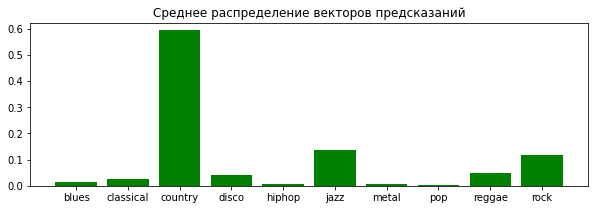

---------------------------------------------------------------
Файл: ./genres/country/country.00052.au
Векторы для предсказания: (1292, 37)
Классификация сети: country - ВЕРНО :-)


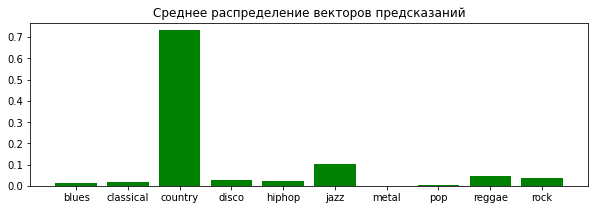

---------------------------------------------------------------
Файл: ./genres/country/country.00053.au
Векторы для предсказания: (1292, 37)
Классификация сети: country - ВЕРНО :-)


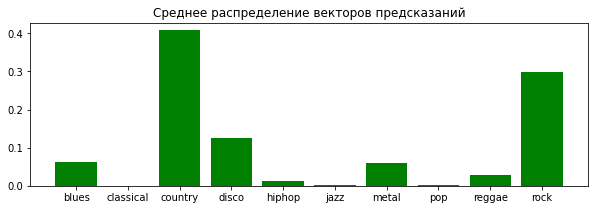

---------------------------------------------------------------
Файл: ./genres/country/country.00054.au
Векторы для предсказания: (1292, 37)
Классификация сети: country - ВЕРНО :-)


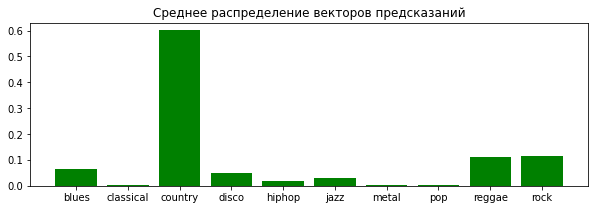

---------------------------------------------------------------
Файл: ./genres/disco/disco.00050.au
Векторы для предсказания: (1292, 37)
Классификация сети: disco - ВЕРНО :-)


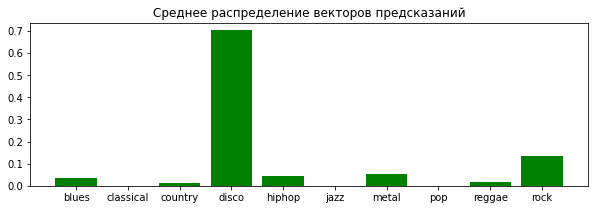

---------------------------------------------------------------
Файл: ./genres/disco/disco.00051.au
Векторы для предсказания: (1292, 37)
Классификация сети: disco - ВЕРНО :-)


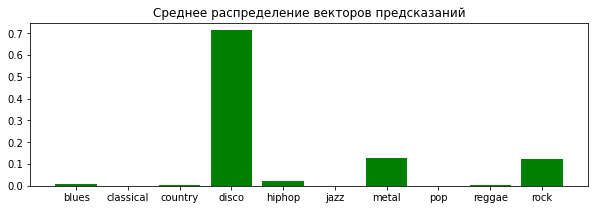

---------------------------------------------------------------
Файл: ./genres/disco/disco.00052.au
Векторы для предсказания: (1292, 37)
Классификация сети: disco - ВЕРНО :-)


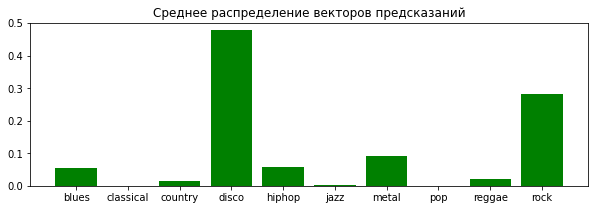

---------------------------------------------------------------
Файл: ./genres/disco/disco.00053.au
Векторы для предсказания: (1292, 37)
Классификация сети: disco - ВЕРНО :-)


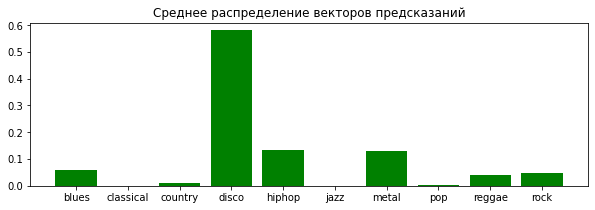

---------------------------------------------------------------
Файл: ./genres/disco/disco.00054.au
Векторы для предсказания: (1292, 37)
Классификация сети: disco - ВЕРНО :-)


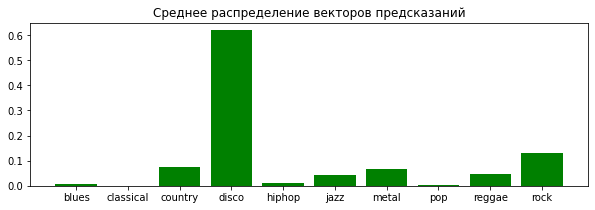

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00050.au
Векторы для предсказания: (1292, 37)
Классификация сети: hiphop - ВЕРНО :-)


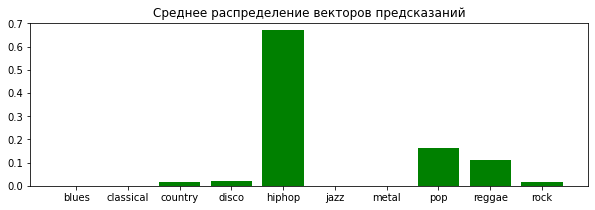

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00051.au
Векторы для предсказания: (1292, 37)
Классификация сети: hiphop - ВЕРНО :-)


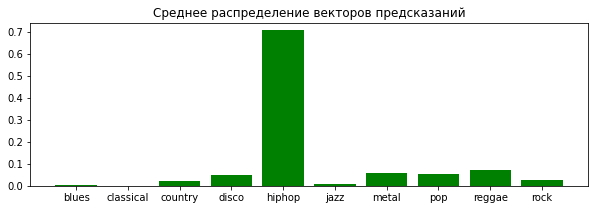

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00052.au
Векторы для предсказания: (1292, 37)
Классификация сети: hiphop - ВЕРНО :-)


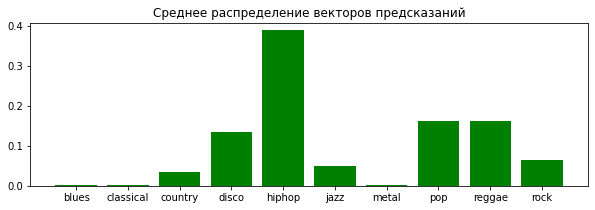

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00053.au
Векторы для предсказания: (1292, 37)
Классификация сети: hiphop - ВЕРНО :-)


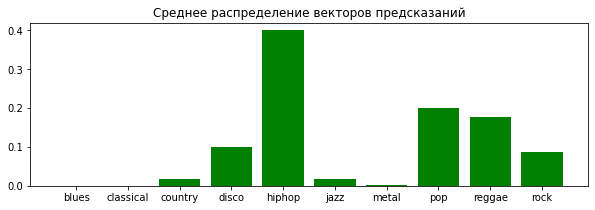

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00054.au
Векторы для предсказания: (1292, 37)
Классификация сети: hiphop - ВЕРНО :-)


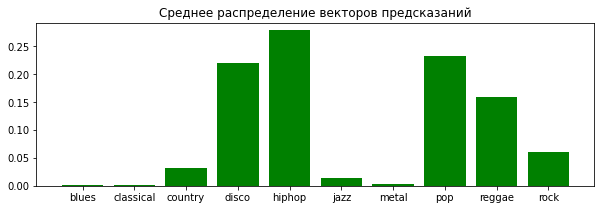

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00050.au
Векторы для предсказания: (1292, 37)
Классификация сети: jazz - ВЕРНО :-)


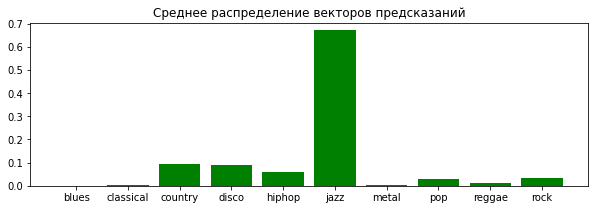

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00051.au
Векторы для предсказания: (1292, 37)
Классификация сети: jazz - ВЕРНО :-)


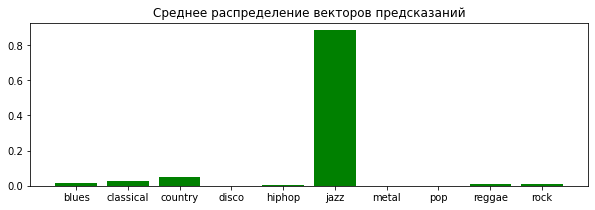

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00052.au
Векторы для предсказания: (1292, 37)
Классификация сети: jazz - ВЕРНО :-)


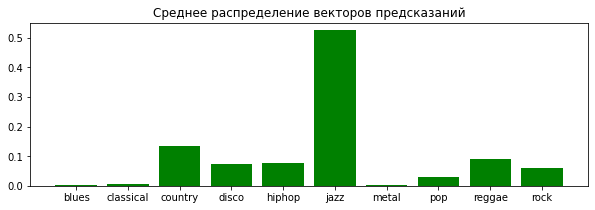

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00053.au
Векторы для предсказания: (1292, 37)
Классификация сети: jazz - ВЕРНО :-)


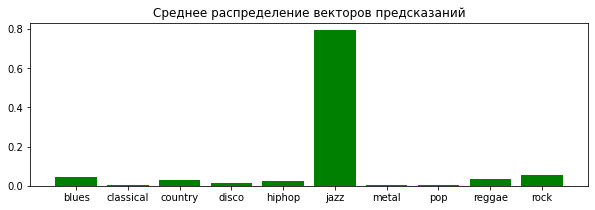

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00054.au
Векторы для предсказания: (1292, 37)
Классификация сети: jazz - ВЕРНО :-)


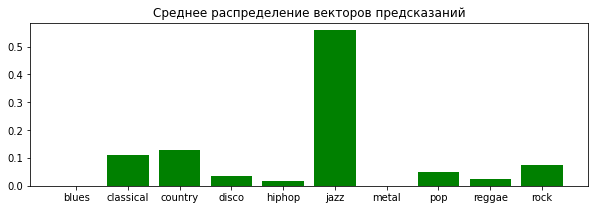

---------------------------------------------------------------
Файл: ./genres/metal/metal.00050.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - ВЕРНО :-)


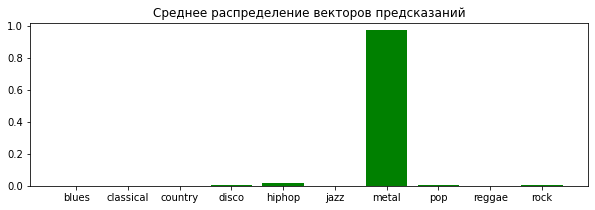

---------------------------------------------------------------
Файл: ./genres/metal/metal.00051.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - ВЕРНО :-)


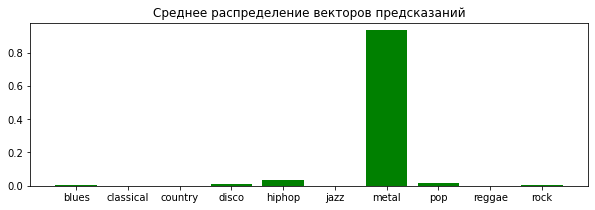

---------------------------------------------------------------
Файл: ./genres/metal/metal.00052.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - ВЕРНО :-)


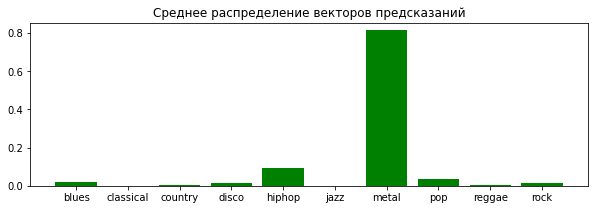

---------------------------------------------------------------
Файл: ./genres/metal/metal.00053.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - ВЕРНО :-)


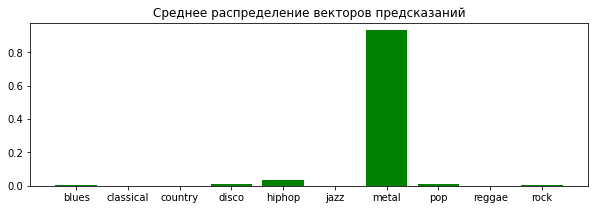

---------------------------------------------------------------
Файл: ./genres/metal/metal.00054.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - ВЕРНО :-)


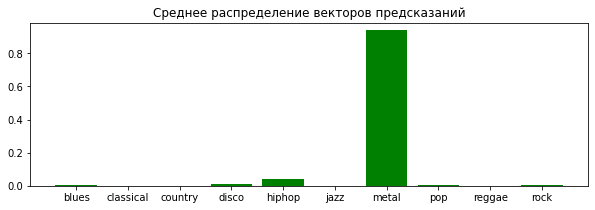

---------------------------------------------------------------
Файл: ./genres/pop/pop.00050.au
Векторы для предсказания: (1292, 37)
Классификация сети: pop - ВЕРНО :-)


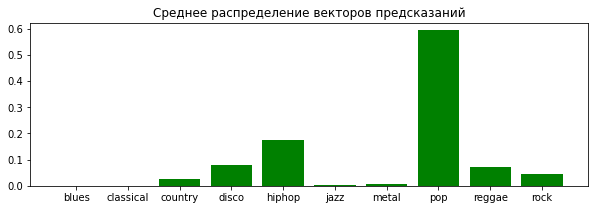

---------------------------------------------------------------
Файл: ./genres/pop/pop.00051.au
Векторы для предсказания: (1292, 37)
Классификация сети: pop - ВЕРНО :-)


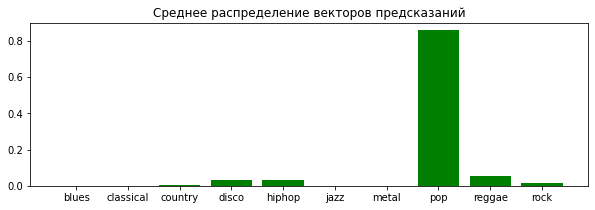

---------------------------------------------------------------
Файл: ./genres/pop/pop.00052.au
Векторы для предсказания: (1292, 37)
Классификация сети: pop - ВЕРНО :-)


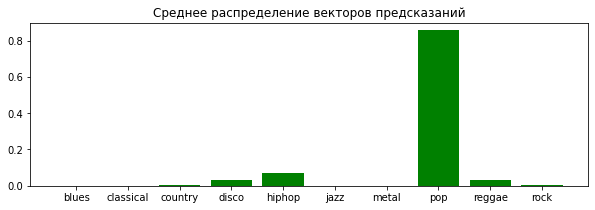

---------------------------------------------------------------
Файл: ./genres/pop/pop.00053.au
Векторы для предсказания: (1292, 37)
Классификация сети: pop - ВЕРНО :-)


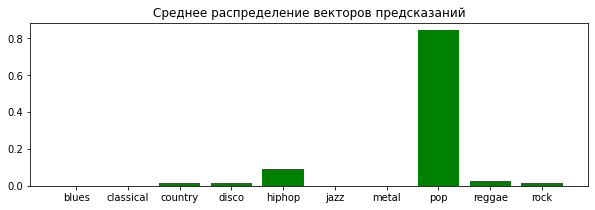

---------------------------------------------------------------
Файл: ./genres/pop/pop.00054.au
Векторы для предсказания: (1292, 37)
Классификация сети: pop - ВЕРНО :-)


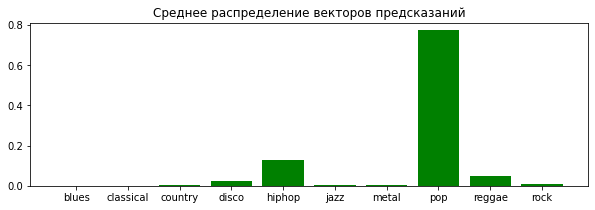

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00050.au
Векторы для предсказания: (1292, 37)
Классификация сети: reggae - ВЕРНО :-)


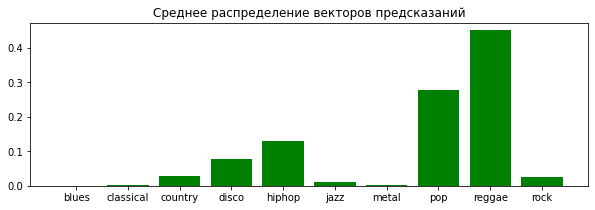

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00051.au
Векторы для предсказания: (1292, 37)
Классификация сети: reggae - ВЕРНО :-)


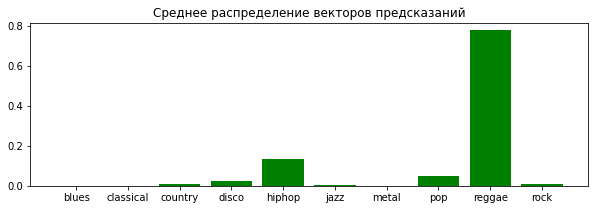

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00052.au
Векторы для предсказания: (1292, 37)
Классификация сети: pop - НЕВЕРНО.


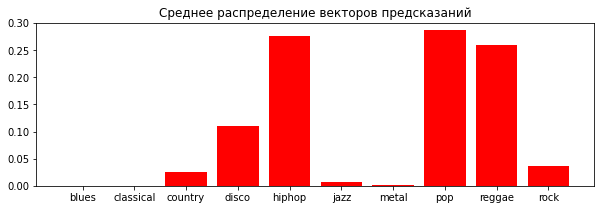

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00053.au
Векторы для предсказания: (1292, 37)
Классификация сети: reggae - ВЕРНО :-)


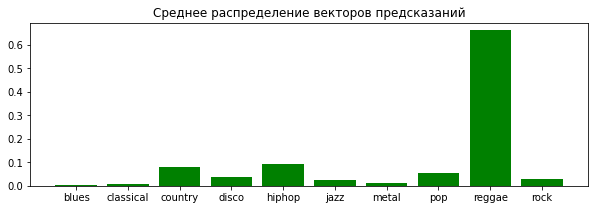

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00054.au
Векторы для предсказания: (1292, 37)
Классификация сети: reggae - ВЕРНО :-)


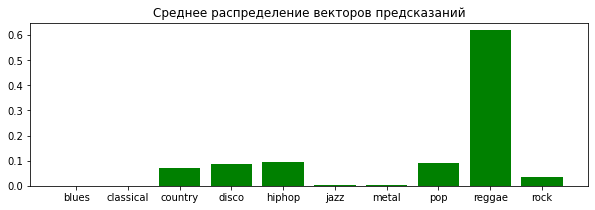

---------------------------------------------------------------
Файл: ./genres/rock/rock.00050.au
Векторы для предсказания: (1292, 37)
Классификация сети: rock - ВЕРНО :-)


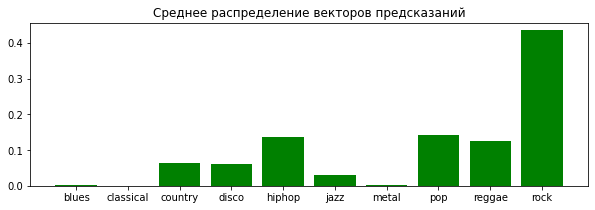

---------------------------------------------------------------
Файл: ./genres/rock/rock.00051.au
Векторы для предсказания: (1292, 37)
Классификация сети: rock - ВЕРНО :-)


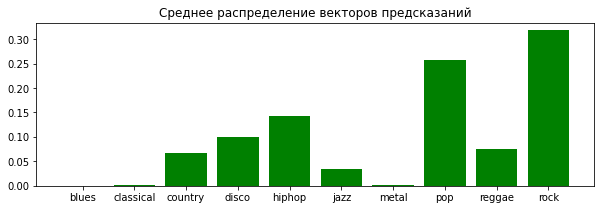

---------------------------------------------------------------
Файл: ./genres/rock/rock.00052.au
Векторы для предсказания: (1292, 37)
Классификация сети: pop - НЕВЕРНО.


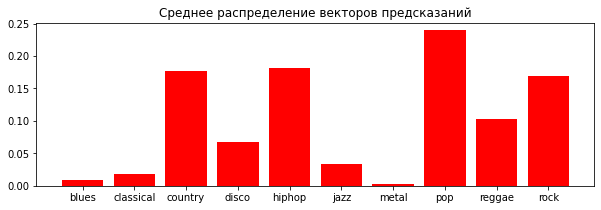

---------------------------------------------------------------
Файл: ./genres/rock/rock.00053.au
Векторы для предсказания: (1292, 37)
Классификация сети: rock - ВЕРНО :-)


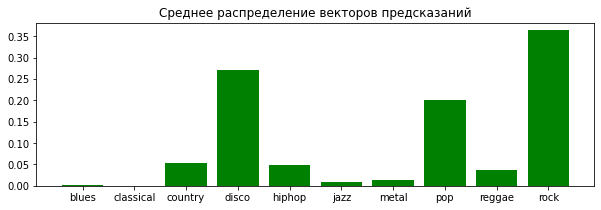

---------------------------------------------------------------
Файл: ./genres/rock/rock.00054.au
Векторы для предсказания: (1292, 37)
Классификация сети: rock - ВЕРНО :-)


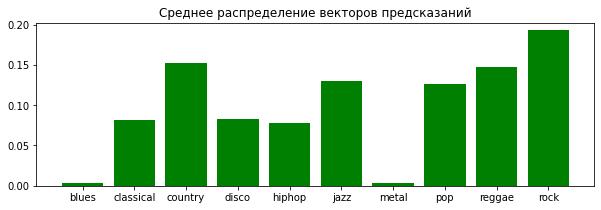

---------------------------------------------------------------
=== Обработано образцов: 50, из них распознано верно: 48, доля верных: 96.0% ===


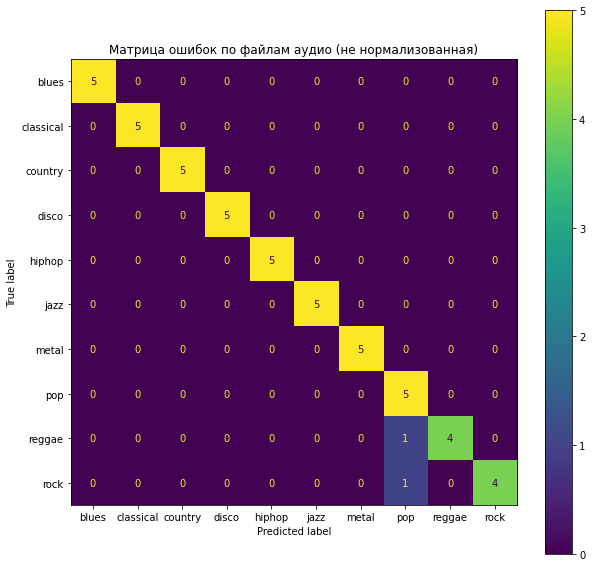

In [ ]:
# Визуализация классификации файлов из тренировочного набора
classify_test_files(model, x_scaler, 50, 5)

###Визуализация на файлах тестового набора

Файл: ./genres/blues/blues.00095.au
Векторы для предсказания: (1292, 37)
Классификация сети: blues - ВЕРНО :-)


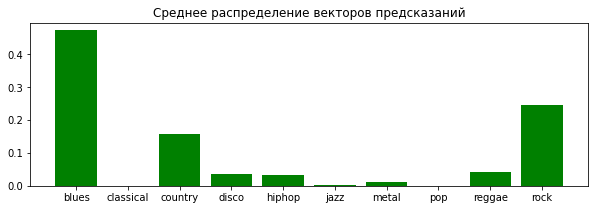

---------------------------------------------------------------
Файл: ./genres/blues/blues.00096.au
Векторы для предсказания: (1292, 37)
Классификация сети: country - НЕВЕРНО.


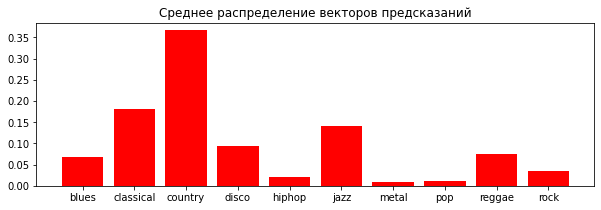

---------------------------------------------------------------
Файл: ./genres/blues/blues.00097.au
Векторы для предсказания: (1292, 37)
Классификация сети: blues - ВЕРНО :-)


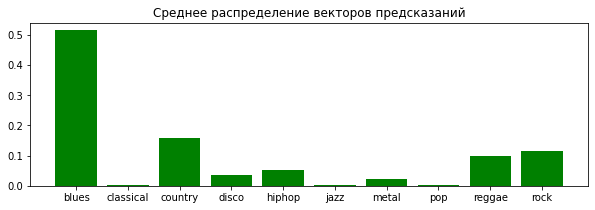

---------------------------------------------------------------
Файл: ./genres/blues/blues.00098.au
Векторы для предсказания: (1292, 37)
Классификация сети: rock - НЕВЕРНО.


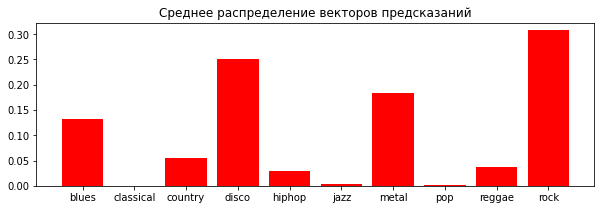

---------------------------------------------------------------
Файл: ./genres/blues/blues.00099.au
Векторы для предсказания: (1292, 37)
Классификация сети: jazz - НЕВЕРНО.


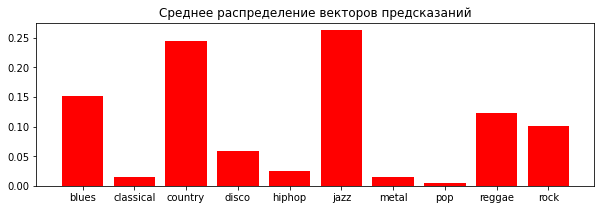

---------------------------------------------------------------
Файл: ./genres/classical/classical.00095.au
Векторы для предсказания: (1292, 37)
Классификация сети: classical - ВЕРНО :-)


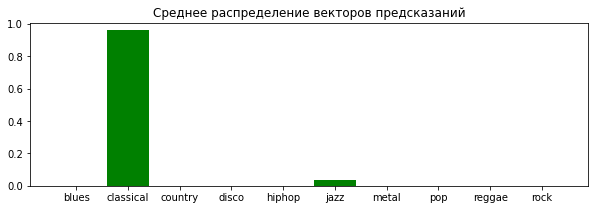

---------------------------------------------------------------
Файл: ./genres/classical/classical.00096.au
Векторы для предсказания: (1292, 37)
Классификация сети: classical - ВЕРНО :-)


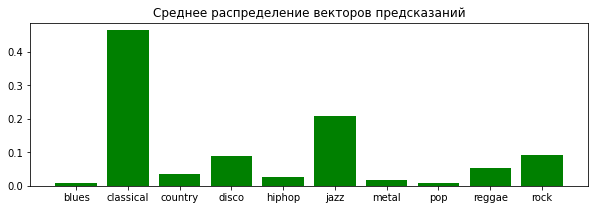

---------------------------------------------------------------
Файл: ./genres/classical/classical.00097.au
Векторы для предсказания: (1292, 37)
Классификация сети: jazz - НЕВЕРНО.


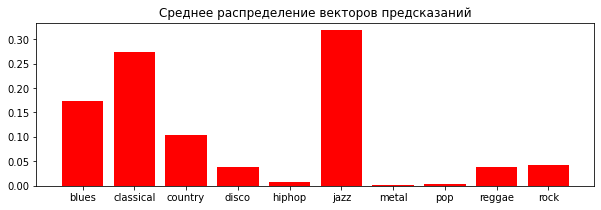

---------------------------------------------------------------
Файл: ./genres/classical/classical.00098.au
Векторы для предсказания: (1292, 37)
Классификация сети: classical - ВЕРНО :-)


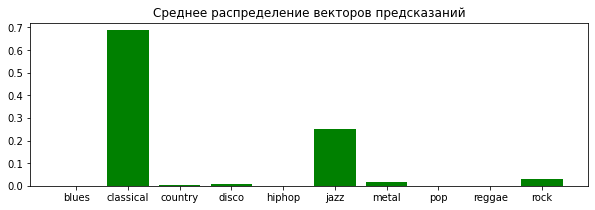

---------------------------------------------------------------
Файл: ./genres/classical/classical.00099.au
Векторы для предсказания: (1292, 37)
Классификация сети: classical - ВЕРНО :-)


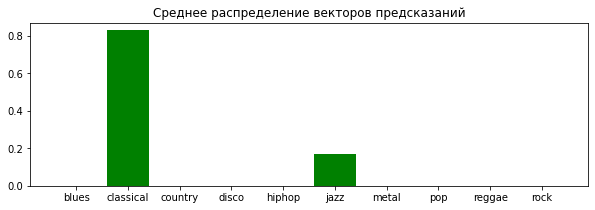

---------------------------------------------------------------
Файл: ./genres/country/country.00095.au
Векторы для предсказания: (1292, 37)
Классификация сети: blues - НЕВЕРНО.


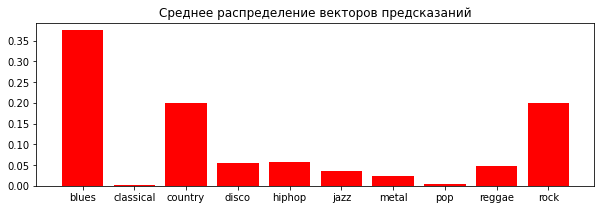

---------------------------------------------------------------
Файл: ./genres/country/country.00096.au
Векторы для предсказания: (1292, 37)
Классификация сети: blues - НЕВЕРНО.


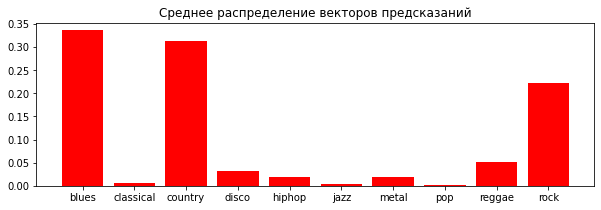

---------------------------------------------------------------
Файл: ./genres/country/country.00097.au
Векторы для предсказания: (1292, 37)
Классификация сети: country - ВЕРНО :-)


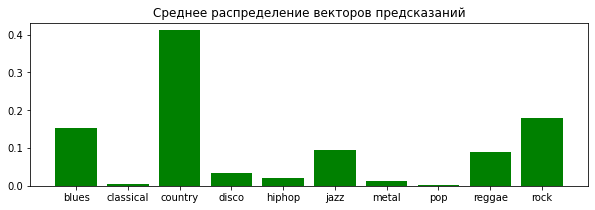

---------------------------------------------------------------
Файл: ./genres/country/country.00098.au
Векторы для предсказания: (1292, 37)
Классификация сети: blues - НЕВЕРНО.


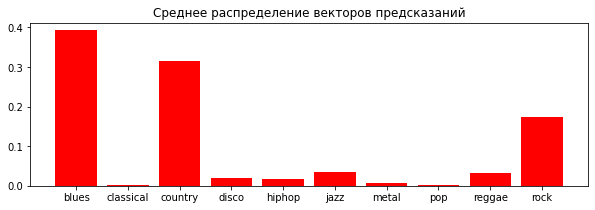

---------------------------------------------------------------
Файл: ./genres/country/country.00099.au
Векторы для предсказания: (1292, 37)
Классификация сети: blues - НЕВЕРНО.


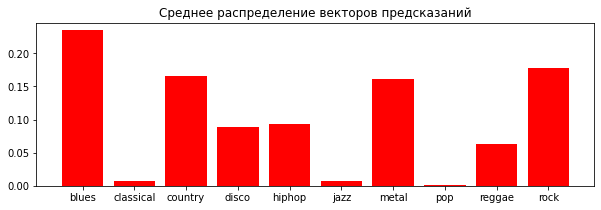

---------------------------------------------------------------
Файл: ./genres/disco/disco.00095.au
Векторы для предсказания: (1292, 37)
Классификация сети: reggae - НЕВЕРНО.


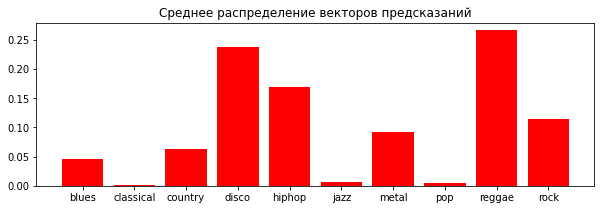

---------------------------------------------------------------
Файл: ./genres/disco/disco.00096.au
Векторы для предсказания: (1292, 37)
Классификация сети: rock - НЕВЕРНО.


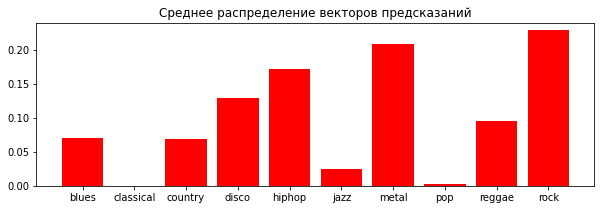

---------------------------------------------------------------
Файл: ./genres/disco/disco.00097.au
Векторы для предсказания: (1292, 37)
Классификация сети: disco - ВЕРНО :-)


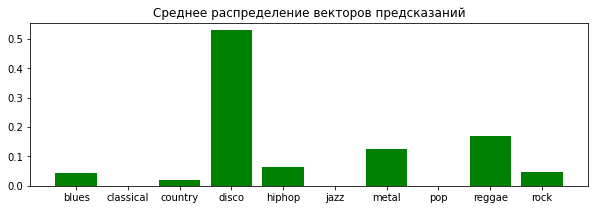

---------------------------------------------------------------
Файл: ./genres/disco/disco.00098.au
Векторы для предсказания: (1292, 37)
Классификация сети: disco - ВЕРНО :-)


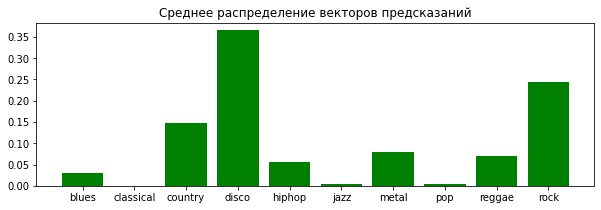

---------------------------------------------------------------
Файл: ./genres/disco/disco.00099.au
Векторы для предсказания: (1292, 37)
Классификация сети: disco - ВЕРНО :-)


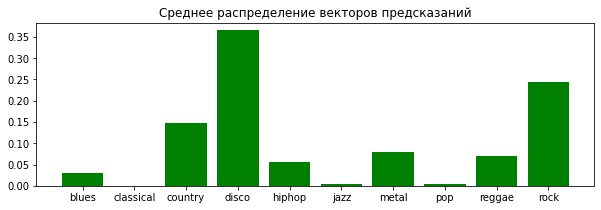

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00095.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - НЕВЕРНО.


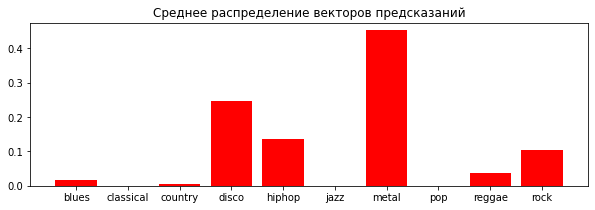

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00096.au
Векторы для предсказания: (1292, 37)
Классификация сети: hiphop - ВЕРНО :-)


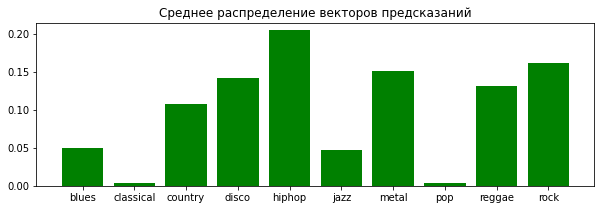

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00097.au
Векторы для предсказания: (1292, 37)
Классификация сети: hiphop - ВЕРНО :-)


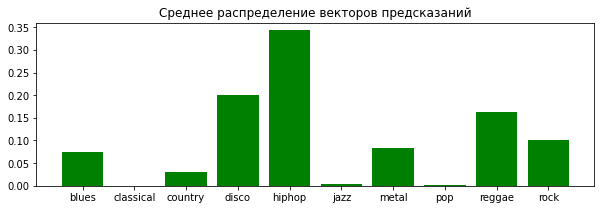

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00098.au
Векторы для предсказания: (1292, 37)
Классификация сети: hiphop - ВЕРНО :-)


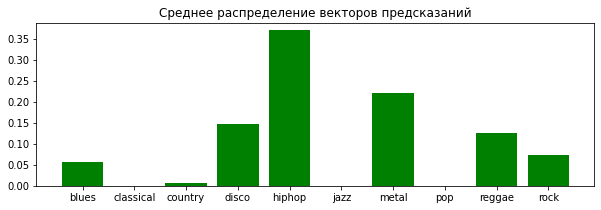

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00099.au
Векторы для предсказания: (1292, 37)
Классификация сети: hiphop - ВЕРНО :-)


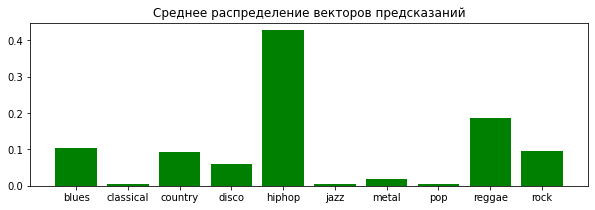

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00095.au
Векторы для предсказания: (1292, 37)
Классификация сети: jazz - ВЕРНО :-)


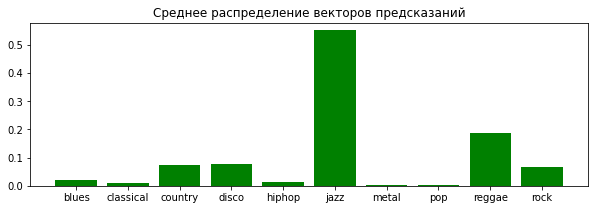

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00096.au
Векторы для предсказания: (1292, 37)
Классификация сети: jazz - ВЕРНО :-)


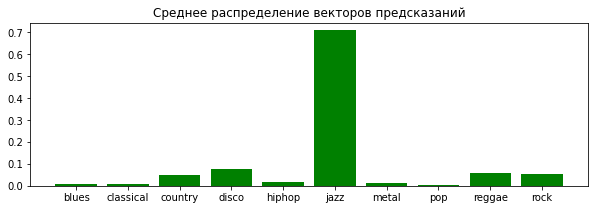

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00097.au
Векторы для предсказания: (1292, 37)
Классификация сети: jazz - ВЕРНО :-)


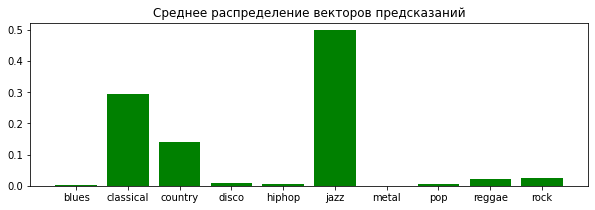

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00098.au
Векторы для предсказания: (1292, 37)
Классификация сети: jazz - ВЕРНО :-)


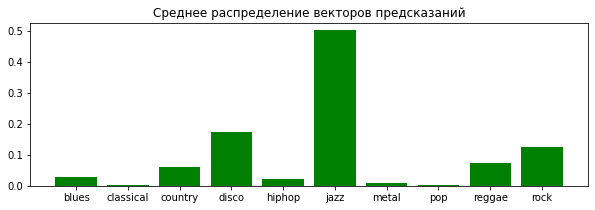

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00099.au
Векторы для предсказания: (1292, 37)
Классификация сети: jazz - ВЕРНО :-)


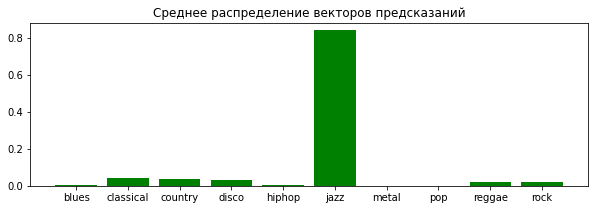

---------------------------------------------------------------
Файл: ./genres/metal/metal.00095.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - ВЕРНО :-)


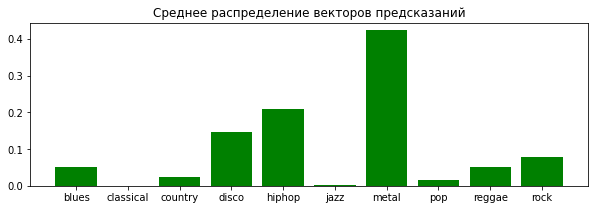

---------------------------------------------------------------
Файл: ./genres/metal/metal.00096.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - ВЕРНО :-)


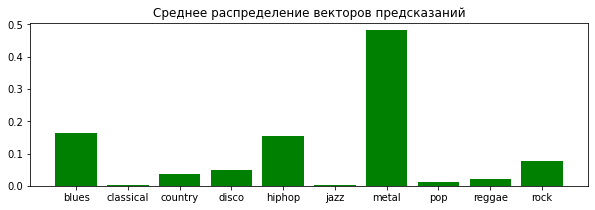

---------------------------------------------------------------
Файл: ./genres/metal/metal.00097.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - ВЕРНО :-)


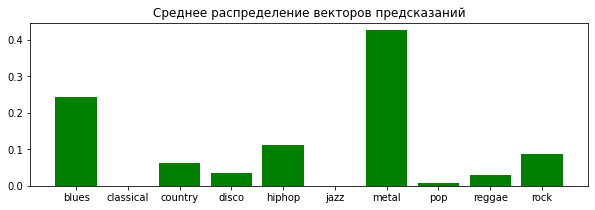

---------------------------------------------------------------
Файл: ./genres/metal/metal.00098.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - ВЕРНО :-)


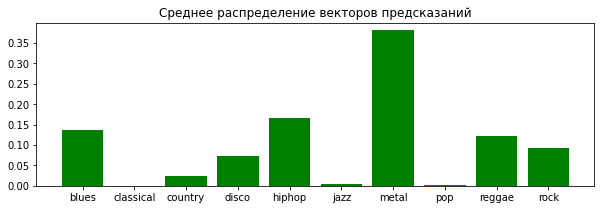

---------------------------------------------------------------
Файл: ./genres/metal/metal.00099.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - ВЕРНО :-)


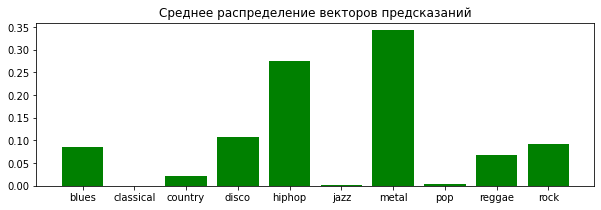

---------------------------------------------------------------
Файл: ./genres/pop/pop.00095.au
Векторы для предсказания: (1292, 37)
Классификация сети: pop - ВЕРНО :-)


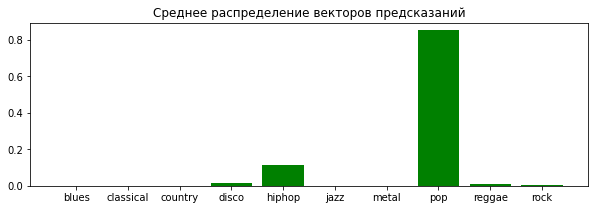

---------------------------------------------------------------
Файл: ./genres/pop/pop.00096.au
Векторы для предсказания: (1292, 37)
Классификация сети: pop - ВЕРНО :-)


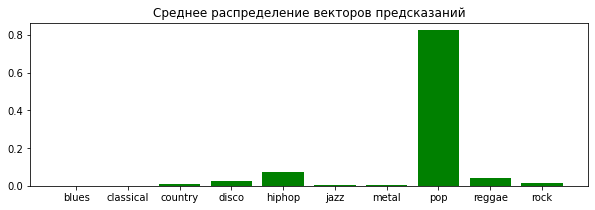

---------------------------------------------------------------
Файл: ./genres/pop/pop.00097.au
Векторы для предсказания: (1292, 37)
Классификация сети: pop - ВЕРНО :-)


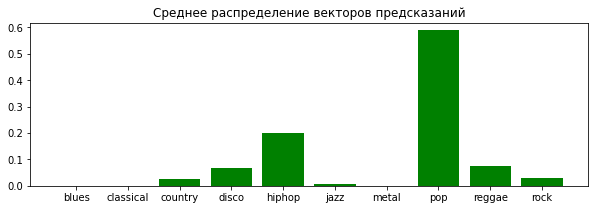

---------------------------------------------------------------
Файл: ./genres/pop/pop.00098.au
Векторы для предсказания: (1292, 37)
Классификация сети: pop - ВЕРНО :-)


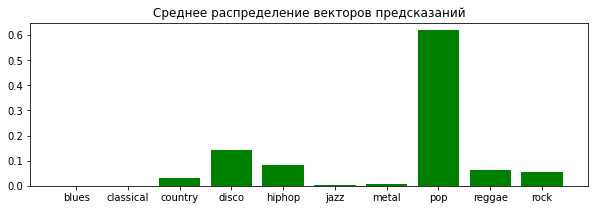

---------------------------------------------------------------
Файл: ./genres/pop/pop.00099.au
Векторы для предсказания: (1292, 37)
Классификация сети: pop - ВЕРНО :-)


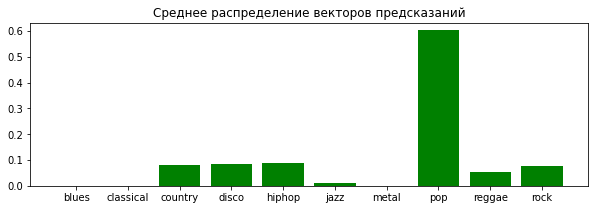

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00095.au
Векторы для предсказания: (1292, 37)
Классификация сети: hiphop - НЕВЕРНО.


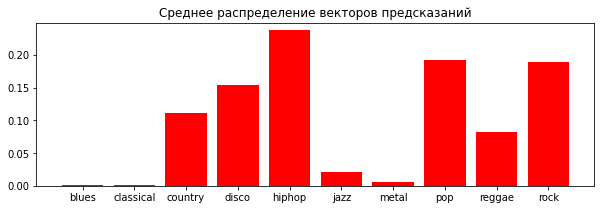

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00096.au
Векторы для предсказания: (1292, 37)
Классификация сети: reggae - ВЕРНО :-)


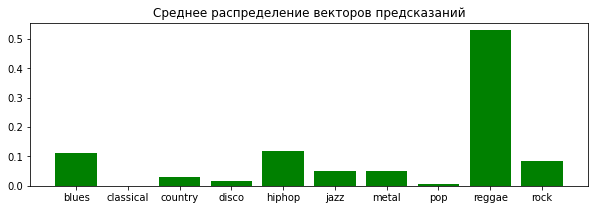

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00097.au
Векторы для предсказания: (1292, 37)
Классификация сети: country - НЕВЕРНО.


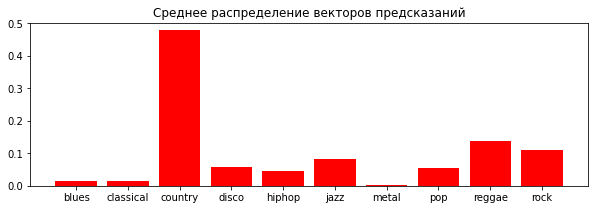

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00098.au
Векторы для предсказания: (1292, 37)
Классификация сети: hiphop - НЕВЕРНО.


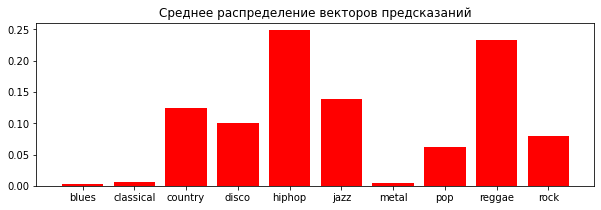

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00099.au
Векторы для предсказания: (1292, 37)
Классификация сети: hiphop - НЕВЕРНО.


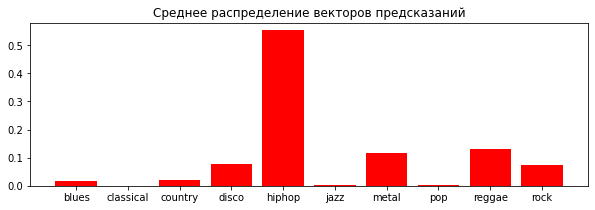

---------------------------------------------------------------
Файл: ./genres/rock/rock.00095.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - НЕВЕРНО.


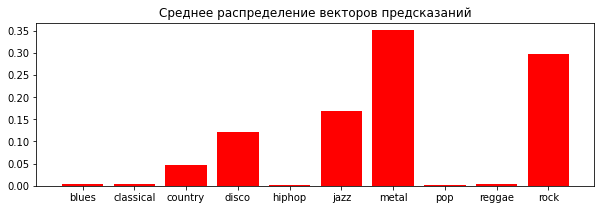

---------------------------------------------------------------
Файл: ./genres/rock/rock.00096.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - НЕВЕРНО.


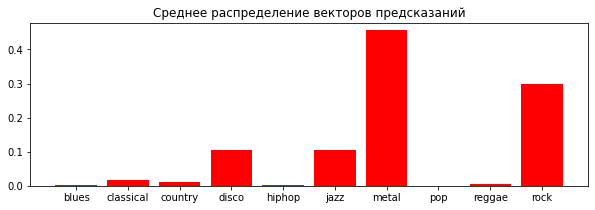

---------------------------------------------------------------
Файл: ./genres/rock/rock.00097.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - НЕВЕРНО.


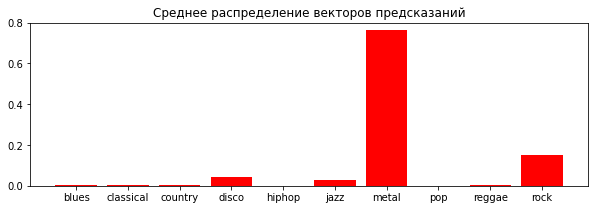

---------------------------------------------------------------
Файл: ./genres/rock/rock.00098.au
Векторы для предсказания: (1292, 37)
Классификация сети: country - НЕВЕРНО.


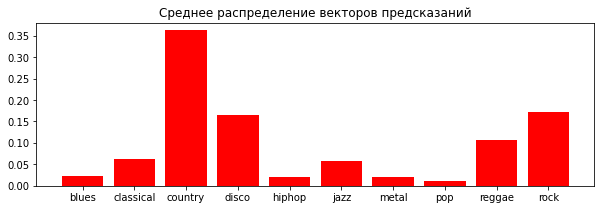

---------------------------------------------------------------
Файл: ./genres/rock/rock.00099.au
Векторы для предсказания: (1292, 37)
Классификация сети: jazz - НЕВЕРНО.


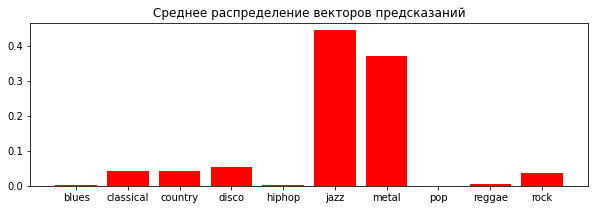

---------------------------------------------------------------
=== Обработано образцов: 50, из них распознано верно: 30, доля верных: 60.0% ===


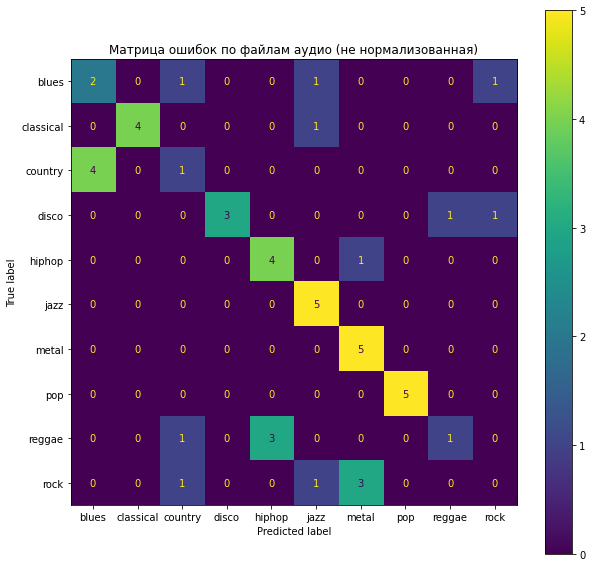

In [ ]:
# Визуализация классификации файлов из тестового набора
classify_test_files(model, x_scaler, 95, 5)

##Методика подбора значимых параметров для обучения модели

In [ ]:
# Функция создания и обучения упрощенной архитектуры классификатора

def create_train_small_classifier(index_list,       # список номеров признаков в списке
                                  x_train=x_train,  # обучающая выборка - вход
                                  y_train=y_train,  # обучающая выборка - выход
                                  x_val=x_val,      # проверочная выборка - вход
                                  y_val=y_val,      # проверочная выборка - выход
                                  epochs=120,       # количество эпох обучения
                                  batch_size=2048,  # размер батча
                                  verbose=0         # подробность вывода при обучении
                                  ):
    # Сборка модели
    model = Sequential()
    model.add(Dense(200, activation='elu', input_shape=(len(index_list),)))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(lr=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    # Обучение модели на подмножестве признаков
    history = model.fit(x_train[:, index_list],
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=verbose,
                        validation_data=(x_val[:, index_list], y_val))

    # Вывод графика точности распознавания на обучающей и проверочной выборках
    plt.figure(figsize=(12,5))
    plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
    plt.plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
    plt.xticks(range(0, epochs, 10))
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()
    print('Точность в конце обучения:',
          history.history['accuracy'][-1],
          history.history['val_accuracy'][-1])
    
    return model

В функции `get_features()` признаки добавляются в следующем порядке индексов:

* **0**: 'rmse' - Среднеквадратическая амплитуда;
* **1**: 'spct' - Спектральный центроид;
* **2**: 'spbw' - Ширина полосы частот;
* **3**: 'roff' - Спектральный спад частоты;
* **4**: 'zcr' - Пересечения нуля;
* **5-24**: 'mfcc' - Мел-кепстральные коэффициенты (20 признаков);
* **25-36**: 'stft' - Хромаграмма (12 признаков).

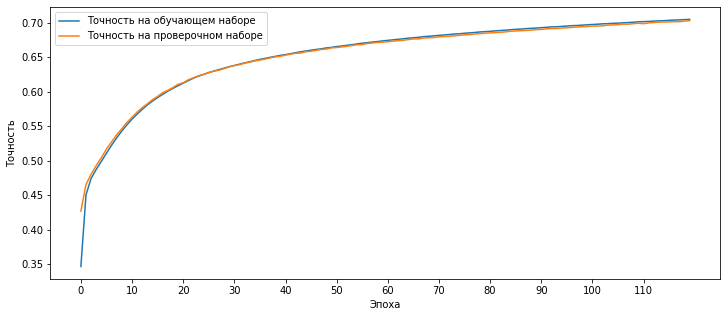

Точность в конце обучения: 0.7046051621437073 0.7025972008705139


In [ ]:
# Обучение малой модели: все параметры
model_small = create_train_small_classifier(range(0, 37))

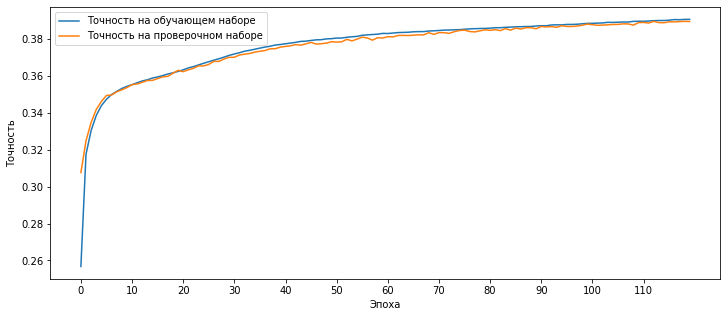

Точность в конце обучения: 0.3904987871646881 0.3893274962902069


In [ ]:
# Обучение малой модели: все параметры кроме мел-коэффициентов и хромаграммы
model_small = create_train_small_classifier(range(0, 5))

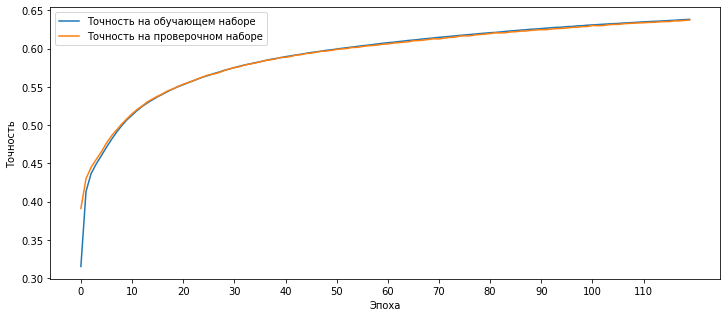

Точность в конце обучения: 0.638242244720459 0.6373150944709778


In [ ]:
# Обучение малой модели: только мел-коэффициенты
model_small = create_train_small_classifier(range(5, 25))

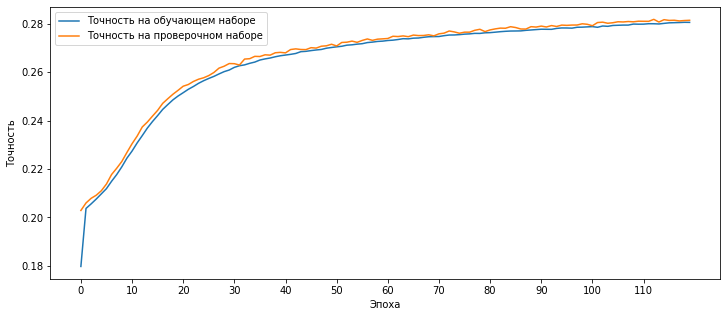

Точность в конце обучения: 0.2805541753768921 0.28141555190086365


In [ ]:
# Обучение малой модели: только хромаграмма
model_small = create_train_small_classifier(range(25, 37))

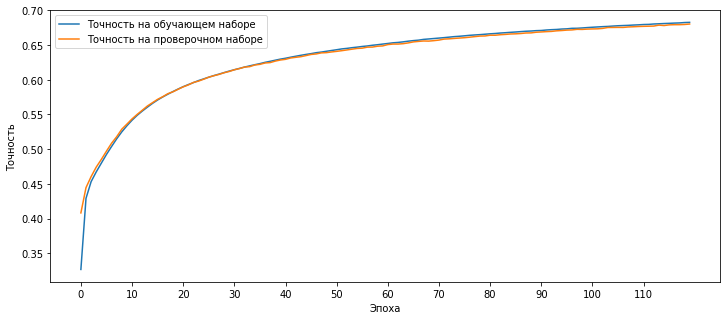

Точность в конце обучения: 0.6827202439308167 0.6802889704704285


In [ ]:
# Обучение малой модели: мел-коэффициенты и хромаграмма
model_small = create_train_small_classifier(range(5, 37))

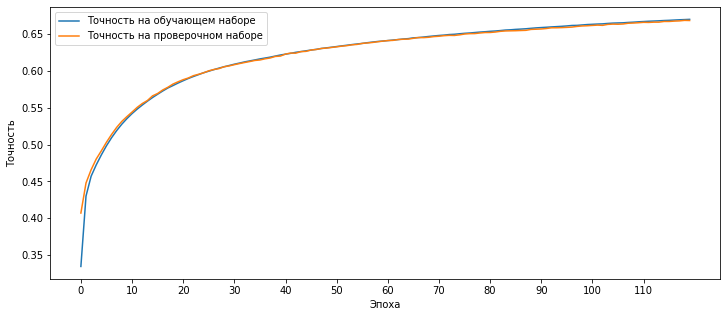

Точность в конце обучения: 0.669799268245697 0.6682232618331909


In [ ]:
# Обучение малой модели: все параметры кроме хромаграммы
model_small = create_train_small_classifier(range(0, 25))

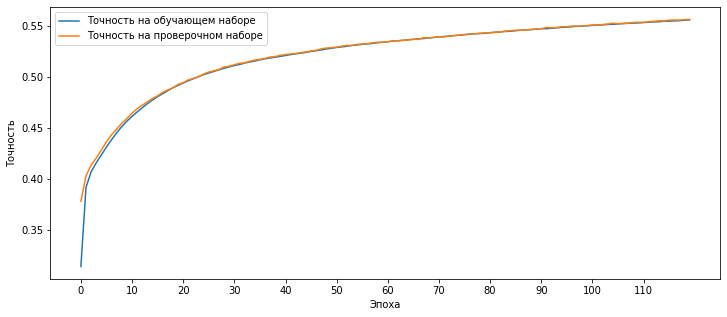

Точность в конце обучения: 0.5560563802719116 0.556630551815033


In [ ]:
# Обучение малой модели: все параметры с шагом 2
model_small = create_train_small_classifier(range(0, 37, 2))

##Пример аугментации данных для повышения точности классификации

In [ ]:
# Все операции в данном блоке выполняются поэлементно; в результате получаются массивы той же формы

# Квадрат значений
x_train_data_sqr = x_train_data ** 2

# Квадратный корень из модулей значений
x_train_data_sqrt = np.abs(x_train_data) ** 0.5

# Обратная величина
x_train_data_inv = 1. / x_train_data

# 2 в степени каждого значения
x_train_data_exp = 2. ** x_train_data

# Формирование нового тренировочного набора данных
x_train_data_aug = np.hstack([x_train_data, x_train_data_sqr, x_train_data_sqrt, x_train_data_exp])

# Проверка формы данных нового набора
print(x_train_data_aug.shape)

(1162798, 148)


In [ ]:
# Нормирование признаков в соответствии со стандартным нормальным распределением
# Замена всех бесконечных значений на 0, иначе нормирование невозможно
x_train_data_aug[np.abs(x_train_data_aug) == math.inf] = 0

x_scaler_aug = StandardScaler()
x_train_data_aug_scaled = x_scaler_aug.fit_transform(x_train_data_aug)

In [ ]:
# Разделение набора данных на обучающую и проверочную выборки
x_train_aug, x_val_aug, y_train_aug, y_val_aug = train_test_split(x_train_data_aug_scaled,
                                                                  y_train_data,
                                                                  test_size=VALIDATION_SPLIT)

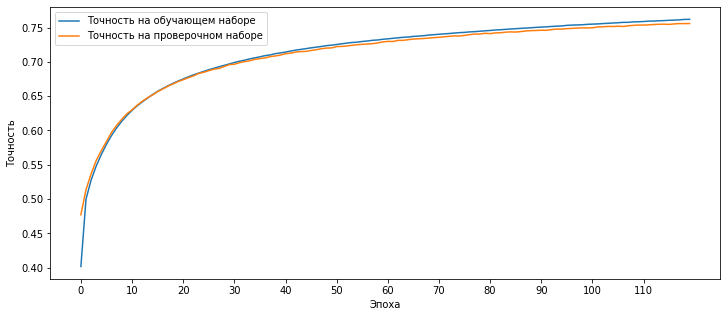

Точность в конце обучения: 0.7619515657424927 0.7558823823928833


In [ ]:
# Обучение малой модели: все параметры + синтетически добавленные (аугментированные)
model_small = create_train_small_classifier(range(x_train_aug.shape[1]),
                                            x_train=x_train_aug,
                                            y_train=y_train_aug,
                                            x_val=x_val_aug,
                                            y_val=y_val_aug)

###Аугментация данных может улучшить результат на той же архитектуре!

##Архитектуры с softmax

In [ ]:
# Функция компиляции и обучения модели с одними и теми же параметрами

def compile_train(model,           # модель нейронной сети
                  epochs=100,      # количество эпох обучения
                  batch_size=4096  # размер батча
                  ):
    # Компиляция
    model.compile(optimizer=Adam(lr=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    # Обучение
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графика обучения
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.show()

Epoch 1/100
256/256 [==============================] - 2s 7ms/step - loss: 2.3470 - accuracy: 0.0884 - val_loss: 2.2725 - val_accuracy: 0.1328
Epoch 2/100
256/256 [==============================] - 2s 6ms/step - loss: 2.2057 - accuracy: 0.1932 - val_loss: 2.1295 - val_accuracy: 0.2428
Epoch 3/100
256/256 [==============================] - 2s 6ms/step - loss: 2.0590 - accuracy: 0.2691 - val_loss: 1.9878 - val_accuracy: 0.2904
Epoch 4/100
256/256 [==============================] - 2s 6ms/step - loss: 1.9386 - accuracy: 0.3009 - val_loss: 1.8910 - val_accuracy: 0.3093
Epoch 5/100
256/256 [==============================] - 2s 6ms/step - loss: 1.8602 - accuracy: 0.3153 - val_loss: 1.8267 - val_accuracy: 0.3226
Epoch 6/100
256/256 [==============================] - 2s 6ms/step - loss: 1.8034 - accuracy: 0.3300 - val_loss: 1.7756 - val_accuracy: 0.3378
Epoch 7/100
256/256 [==============================] - 2s 6ms/step - loss: 1.7563 - accuracy: 0.3456 - val_loss: 1.7316 - val_accuracy: 0.3539

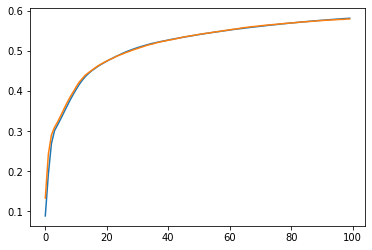

In [ ]:
# Сеть с разными ветками и активациями

# Вход
input1 = Input(x_train.shape[1:])

# Первая ветка с elu
x1 = Dense(10, activation="elu")(input1) 
x1 = Dense(10, activation="elu")(x1)

# Вторая ветка с softmaх
x2 = Dense(10, activation="elu")(input1)
x2 = Dense(40, activation="softmax")(x2)

# Объединение веток
x = concatenate([x1, x2])

# Финальные слои
x = Dense(10, activation='elu')(x)
x = Dense(10, activation='softmax')(x)

# Сборка модели
model = Model(input1, x)

compile_train(model)

Epoch 1/100
256/256 [==============================] - 2s 6ms/step - loss: 2.3487 - accuracy: 0.1107 - val_loss: 2.2381 - val_accuracy: 0.1568
Epoch 2/100
256/256 [==============================] - 1s 5ms/step - loss: 2.1577 - accuracy: 0.1911 - val_loss: 2.0879 - val_accuracy: 0.2213
Epoch 3/100
256/256 [==============================] - 1s 5ms/step - loss: 2.0374 - accuracy: 0.2492 - val_loss: 1.9933 - val_accuracy: 0.2742
Epoch 4/100
256/256 [==============================] - 1s 5ms/step - loss: 1.9601 - accuracy: 0.2870 - val_loss: 1.9286 - val_accuracy: 0.2963
Epoch 5/100
256/256 [==============================] - 1s 5ms/step - loss: 1.9034 - accuracy: 0.3038 - val_loss: 1.8778 - val_accuracy: 0.3104
Epoch 6/100
256/256 [==============================] - 1s 5ms/step - loss: 1.8568 - accuracy: 0.3179 - val_loss: 1.8342 - val_accuracy: 0.3248
Epoch 7/100
256/256 [==============================] - 1s 5ms/step - loss: 1.8153 - accuracy: 0.3316 - val_loss: 1.7941 - val_accuracy: 0.3381

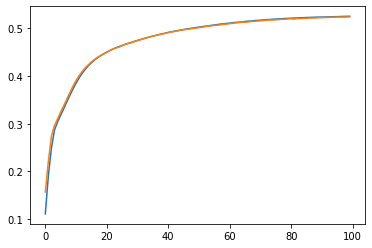

In [ ]:
# Облегченный вариант архитектуры

input1 = Input(x_train.shape[1:])

x1 = Dense(10, activation="elu")(input1)
x1 = Dense(10, activation="elu")(x1)

x = Dense(10, activation='elu')(x1)
x = Dense(10, activation='softmax')(x)

model = Model(input1, x)

compile_train(model)

Epoch 1/100
256/256 [==============================] - 4s 13ms/step - loss: 1.9361 - accuracy: 0.3096 - val_loss: 1.6874 - val_accuracy: 0.3831
Epoch 2/100
256/256 [==============================] - 3s 11ms/step - loss: 1.5876 - accuracy: 0.4260 - val_loss: 1.5058 - val_accuracy: 0.4577
Epoch 3/100
256/256 [==============================] - 3s 11ms/step - loss: 1.4617 - accuracy: 0.4772 - val_loss: 1.4188 - val_accuracy: 0.4931
Epoch 4/100
256/256 [==============================] - 3s 11ms/step - loss: 1.3874 - accuracy: 0.5065 - val_loss: 1.3551 - val_accuracy: 0.5187
Epoch 5/100
256/256 [==============================] - 3s 11ms/step - loss: 1.3283 - accuracy: 0.5292 - val_loss: 1.3011 - val_accuracy: 0.5382
Epoch 6/100
256/256 [==============================] - 3s 11ms/step - loss: 1.2764 - accuracy: 0.5483 - val_loss: 1.2527 - val_accuracy: 0.5576
Epoch 7/100
256/256 [==============================] - 3s 11ms/step - loss: 1.2297 - accuracy: 0.5656 - val_loss: 1.2087 - val_accuracy:

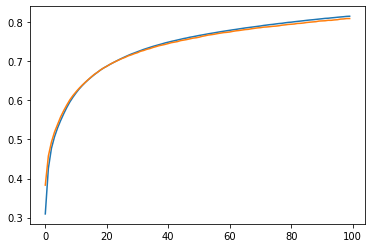

In [ ]:
# Сеть с 7 ветками, разным количеством нейронов и функциями активации

input1 = Input(x_train.shape[1:])

x1 = Dense(64, activation="elu")(input1)
x1 = Dense(64, activation="elu")(x1)

x2 = Dense(64, activation="elu")(input1)
x2 = Dense(40, activation="softmax")(x2)

x3 = Dense(64, activation="elu")(input1)
x3 = Dense(200, activation="softmax")(x3)

x4 = Dense(40, activation="softmax")(input1)

x5 = Dense(200, activation="softmax")(input1)

x6 = Dense(10, activation="softmax")(input1)

x7 = Dense(64, activation="elu")(input1)
x7 = Dense(10, activation="softmax")(x7)

x = concatenate([x1, x2, x3, x4, x5, x6, x7])

x = Dense(64, activation='elu')(x)
x = Dense(10, activation='softmax')(x)

model = Model(input1, x)

compile_train(model)

Epoch 1/100
256/256 [==============================] - 13s 38ms/step - loss: 1.3869 - accuracy: 0.5222 - val_loss: 1.7107 - val_accuracy: 0.3899
Epoch 2/100
256/256 [==============================] - 9s 36ms/step - loss: 1.0238 - accuracy: 0.6467 - val_loss: 1.2215 - val_accuracy: 0.5838
Epoch 3/100
256/256 [==============================] - 9s 36ms/step - loss: 0.8874 - accuracy: 0.6934 - val_loss: 0.8732 - val_accuracy: 0.7002
Epoch 4/100
256/256 [==============================] - 9s 36ms/step - loss: 0.8017 - accuracy: 0.7230 - val_loss: 0.7736 - val_accuracy: 0.7315
Epoch 5/100
256/256 [==============================] - 9s 36ms/step - loss: 0.7418 - accuracy: 0.7434 - val_loss: 0.7207 - val_accuracy: 0.7499
Epoch 6/100
256/256 [==============================] - 9s 36ms/step - loss: 0.6965 - accuracy: 0.7586 - val_loss: 0.6830 - val_accuracy: 0.7630
Epoch 7/100
256/256 [==============================] - 9s 36ms/step - loss: 0.6593 - accuracy: 0.7721 - val_loss: 0.6489 - val_accuracy

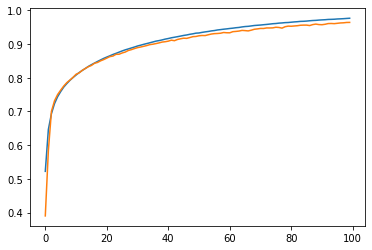

In [ ]:
# Сеть с измененным количеством нейронов в слоях и нормализацией после каждого слоя

input1 = Input(x_train.shape[1:])

x1 = Dense(256, activation="elu")(input1)
x1 = BatchNormalization()(x1)
x1 = Dense(256, activation="elu")(x1)
x1 = BatchNormalization()(x1)

x2 = Dense(256, activation="elu")(input1)
x2 = BatchNormalization()(x2)
x2 = Dense(40, activation="softmax")(x2)
x2 = BatchNormalization()(x2)

x3 = Dense(256, activation="elu")(input1)
x3 = BatchNormalization()(x3)
x3 = Dense(200, activation="softmax")(x3)
x3 = BatchNormalization()(x3)

x4 = Dense(40, activation="softmax")(input1)
x4 = BatchNormalization()(x4)

x5 = Dense(200, activation="softmax")(input1)
x5 = BatchNormalization()(x5)

x6 = Dense(10, activation="softmax")(input1)
x6 = BatchNormalization()(x6)

x7 = Dense(256, activation="elu")(input1)
x7 = BatchNormalization()(x7)
x7 = Dense(10, activation="softmax")(x7)
x7 = BatchNormalization()(x7)

x = concatenate([x1, x2, x3, x4, x5, x6, x7])

x = BatchNormalization()(x)
x = Dense(256, activation='elu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='softmax')(x)

model = Model(input1, x)

compile_train(model)

In [ ]:
# Сохранение/восстановление модели
model.save('/content/model_audio_advanced.h5')
model = load_model('/content/model_audio_advanced.h5')

##Проверка точности предсказаний модели

###Проверка на данных тестовой выборки

3634/3634 [==============================] - 19s 5ms/step - loss: 0.1095 - accuracy: 0.9641
Ошибка: 0.10946892201900482, точность: 0.9640694856643677


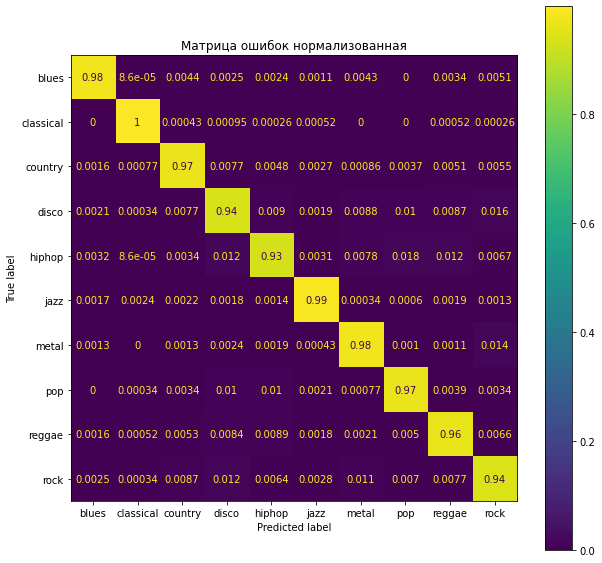

In [ ]:
# Оценка точности сети на проверочной выборке
eval_model(model, x_val, y_val)

4038/4038 [==============================] - 21s 5ms/step - loss: 3.7601 - accuracy: 0.4433
Ошибка: 3.7600574493408203, точность: 0.44326624274253845


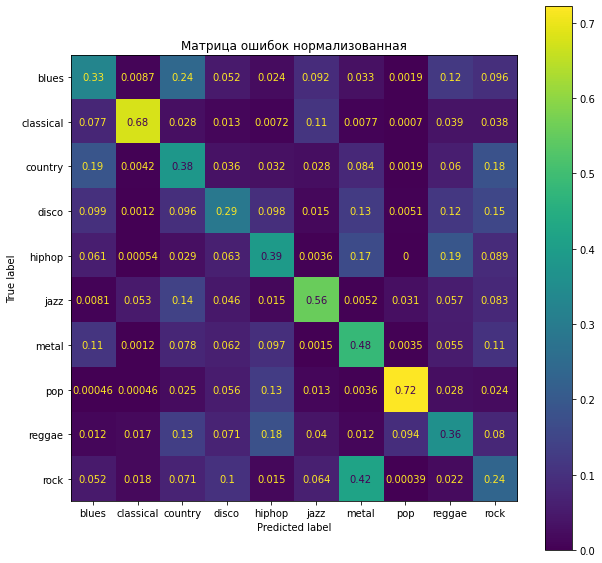

In [ ]:
# Оценка точности сети на тестовой выборке
eval_model(model, x_test, y_test)

###Проверка на звуковых файлах

###Визуализация на файлах тренировочного набора

Файл: ./genres/blues/blues.00050.au
Векторы для предсказания: (1292, 37)
Классификация сети: blues - ВЕРНО :-)


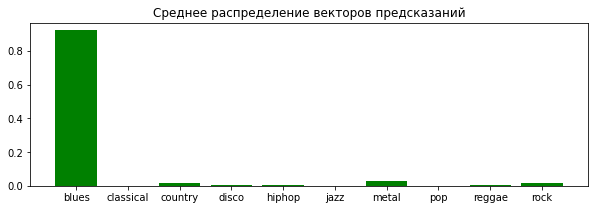

---------------------------------------------------------------
Файл: ./genres/blues/blues.00051.au
Векторы для предсказания: (1292, 37)
Классификация сети: blues - ВЕРНО :-)


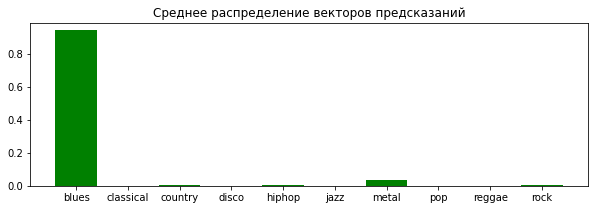

---------------------------------------------------------------
Файл: ./genres/blues/blues.00052.au
Векторы для предсказания: (1292, 37)
Классификация сети: blues - ВЕРНО :-)


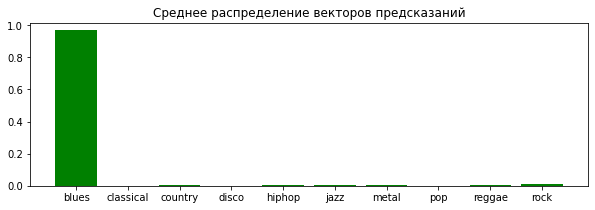

---------------------------------------------------------------
Файл: ./genres/blues/blues.00053.au
Векторы для предсказания: (1292, 37)
Классификация сети: blues - ВЕРНО :-)


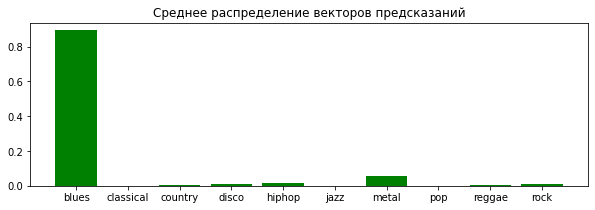

---------------------------------------------------------------
Файл: ./genres/blues/blues.00054.au
Векторы для предсказания: (1292, 37)
Классификация сети: blues - ВЕРНО :-)


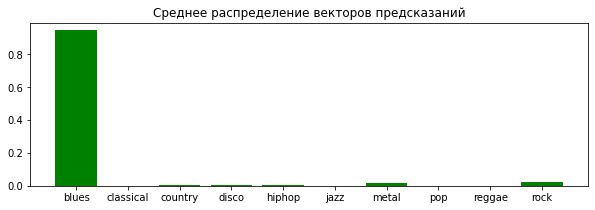

---------------------------------------------------------------
Файл: ./genres/classical/classical.00050.au
Векторы для предсказания: (1292, 37)
Классификация сети: classical - ВЕРНО :-)


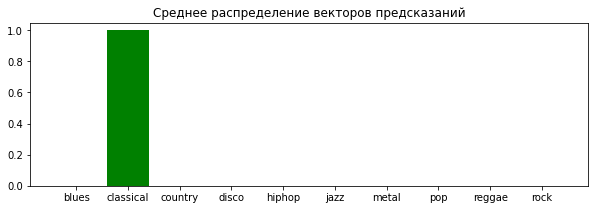

---------------------------------------------------------------
Файл: ./genres/classical/classical.00051.au
Векторы для предсказания: (1292, 37)
Классификация сети: classical - ВЕРНО :-)


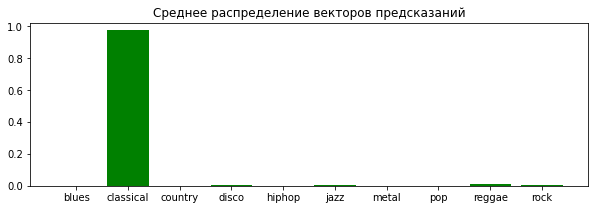

---------------------------------------------------------------
Файл: ./genres/classical/classical.00052.au
Векторы для предсказания: (1292, 37)
Классификация сети: classical - ВЕРНО :-)


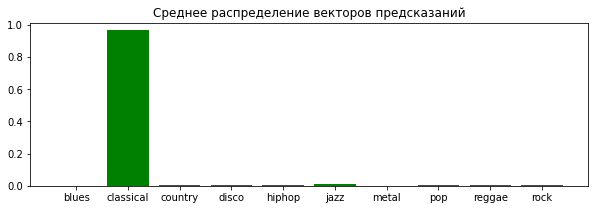

---------------------------------------------------------------
Файл: ./genres/classical/classical.00053.au
Векторы для предсказания: (1292, 37)
Классификация сети: classical - ВЕРНО :-)


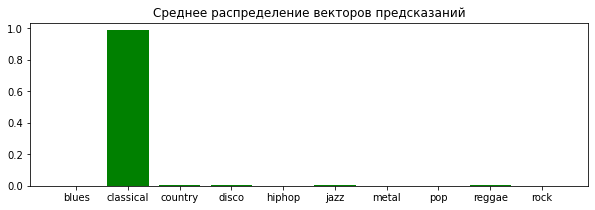

---------------------------------------------------------------
Файл: ./genres/classical/classical.00054.au
Векторы для предсказания: (1292, 37)
Классификация сети: classical - ВЕРНО :-)


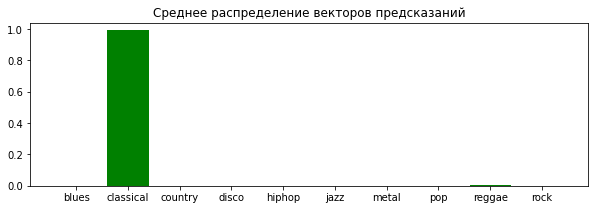

---------------------------------------------------------------
Файл: ./genres/country/country.00050.au
Векторы для предсказания: (1292, 37)
Классификация сети: country - ВЕРНО :-)


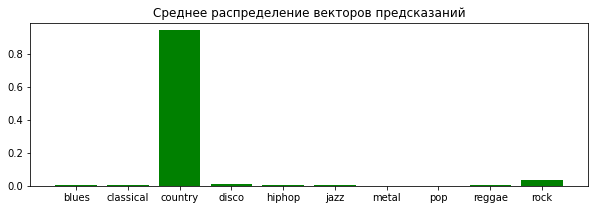

---------------------------------------------------------------
Файл: ./genres/country/country.00051.au
Векторы для предсказания: (1292, 37)
Классификация сети: country - ВЕРНО :-)


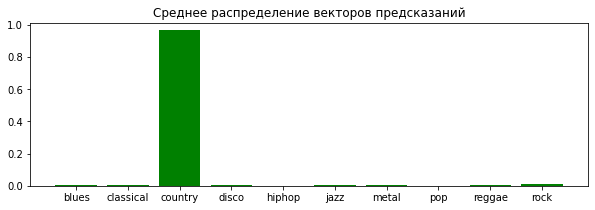

---------------------------------------------------------------
Файл: ./genres/country/country.00052.au
Векторы для предсказания: (1292, 37)
Классификация сети: country - ВЕРНО :-)


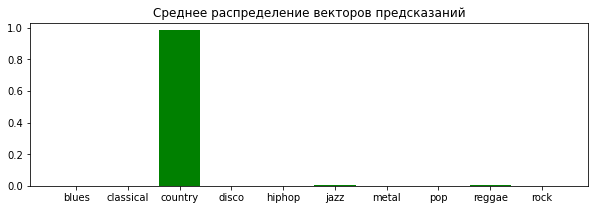

---------------------------------------------------------------
Файл: ./genres/country/country.00053.au
Векторы для предсказания: (1292, 37)
Классификация сети: country - ВЕРНО :-)


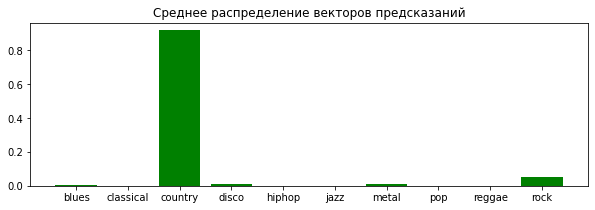

---------------------------------------------------------------
Файл: ./genres/country/country.00054.au
Векторы для предсказания: (1292, 37)
Классификация сети: country - ВЕРНО :-)


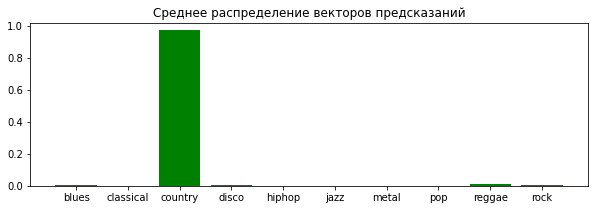

---------------------------------------------------------------
Файл: ./genres/disco/disco.00050.au
Векторы для предсказания: (1292, 37)
Классификация сети: disco - ВЕРНО :-)


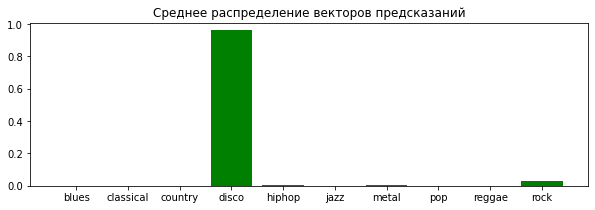

---------------------------------------------------------------
Файл: ./genres/disco/disco.00051.au
Векторы для предсказания: (1292, 37)
Классификация сети: disco - ВЕРНО :-)


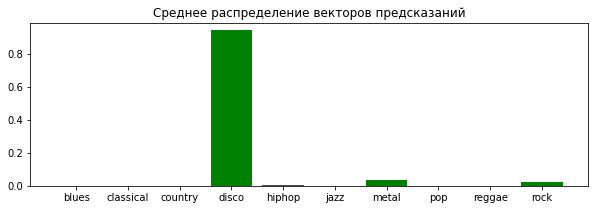

---------------------------------------------------------------
Файл: ./genres/disco/disco.00052.au
Векторы для предсказания: (1292, 37)
Классификация сети: disco - ВЕРНО :-)


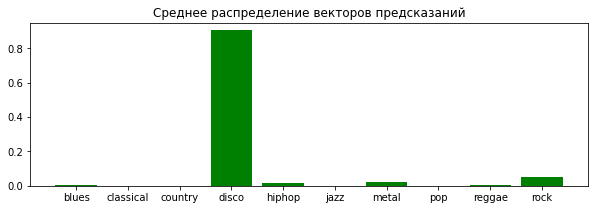

---------------------------------------------------------------
Файл: ./genres/disco/disco.00053.au
Векторы для предсказания: (1292, 37)
Классификация сети: disco - ВЕРНО :-)


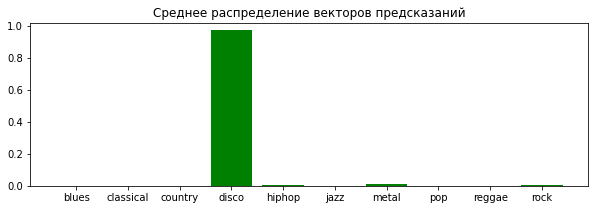

---------------------------------------------------------------
Файл: ./genres/disco/disco.00054.au
Векторы для предсказания: (1292, 37)
Классификация сети: disco - ВЕРНО :-)


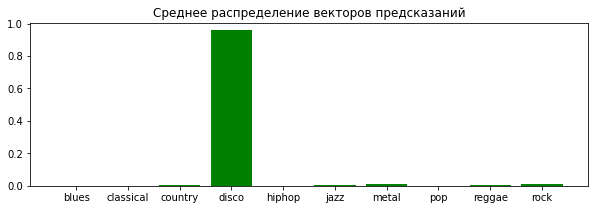

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00050.au
Векторы для предсказания: (1292, 37)
Классификация сети: hiphop - ВЕРНО :-)


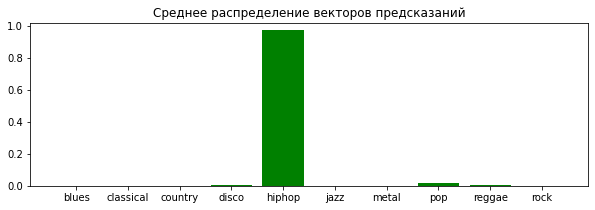

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00051.au
Векторы для предсказания: (1292, 37)
Классификация сети: hiphop - ВЕРНО :-)


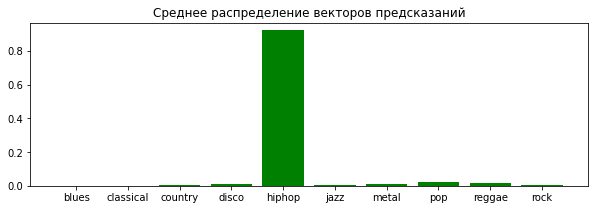

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00052.au
Векторы для предсказания: (1292, 37)
Классификация сети: hiphop - ВЕРНО :-)


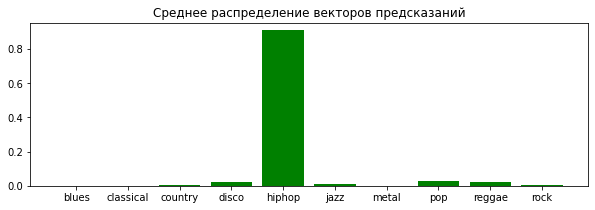

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00053.au
Векторы для предсказания: (1292, 37)
Классификация сети: hiphop - ВЕРНО :-)


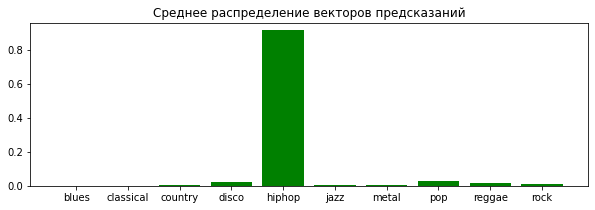

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00054.au
Векторы для предсказания: (1292, 37)
Классификация сети: hiphop - ВЕРНО :-)


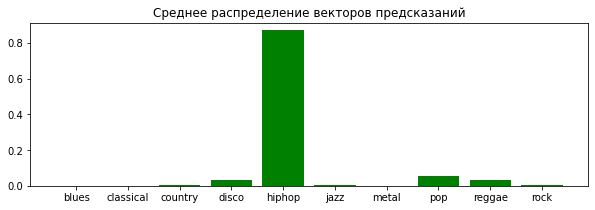

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00050.au
Векторы для предсказания: (1292, 37)
Классификация сети: jazz - ВЕРНО :-)


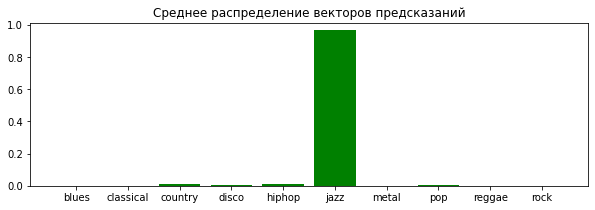

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00051.au
Векторы для предсказания: (1292, 37)
Классификация сети: jazz - ВЕРНО :-)


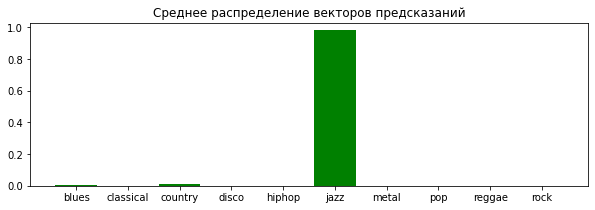

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00052.au
Векторы для предсказания: (1292, 37)
Классификация сети: jazz - ВЕРНО :-)


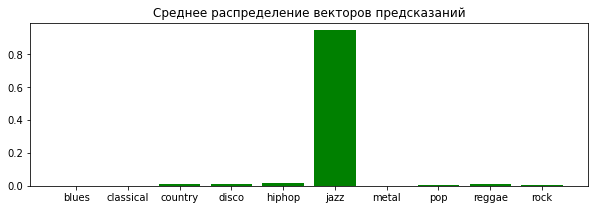

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00053.au
Векторы для предсказания: (1292, 37)
Классификация сети: jazz - ВЕРНО :-)


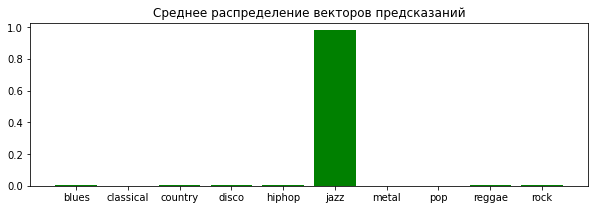

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00054.au
Векторы для предсказания: (1292, 37)
Классификация сети: jazz - ВЕРНО :-)


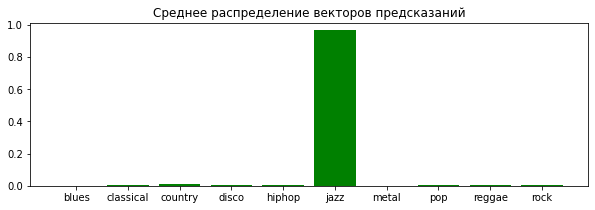

---------------------------------------------------------------
Файл: ./genres/metal/metal.00050.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - ВЕРНО :-)


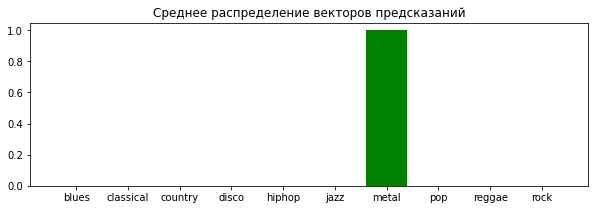

---------------------------------------------------------------
Файл: ./genres/metal/metal.00051.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - ВЕРНО :-)


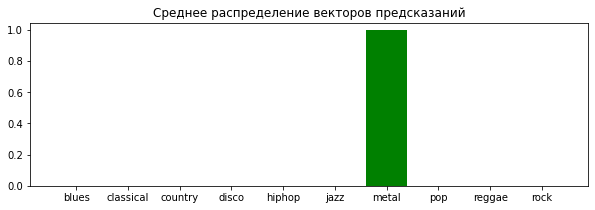

---------------------------------------------------------------
Файл: ./genres/metal/metal.00052.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - ВЕРНО :-)


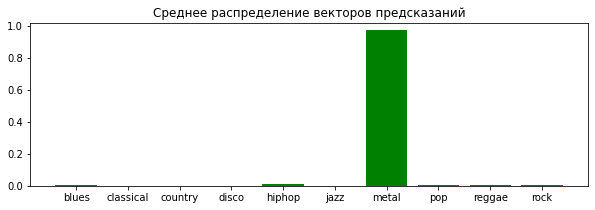

---------------------------------------------------------------
Файл: ./genres/metal/metal.00053.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - ВЕРНО :-)


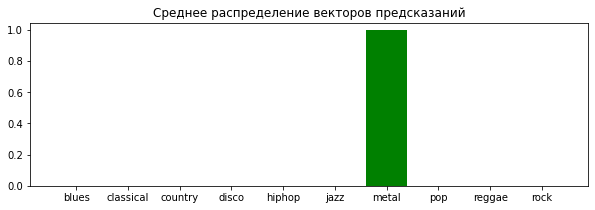

---------------------------------------------------------------
Файл: ./genres/metal/metal.00054.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - ВЕРНО :-)


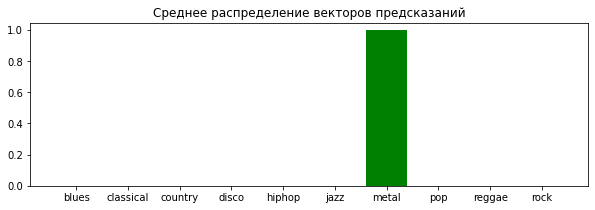

---------------------------------------------------------------
Файл: ./genres/pop/pop.00050.au
Векторы для предсказания: (1292, 37)
Классификация сети: pop - ВЕРНО :-)


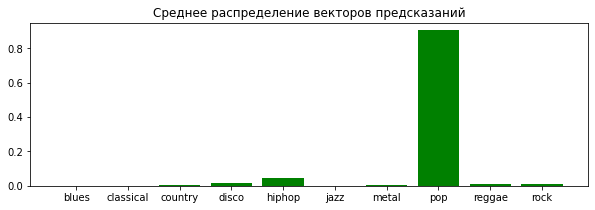

---------------------------------------------------------------
Файл: ./genres/pop/pop.00051.au
Векторы для предсказания: (1292, 37)
Классификация сети: pop - ВЕРНО :-)


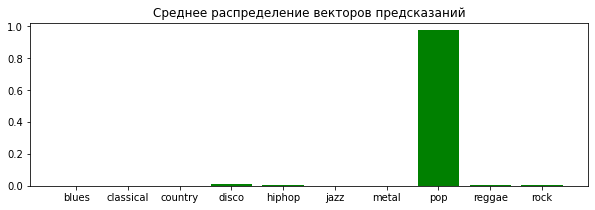

---------------------------------------------------------------
Файл: ./genres/pop/pop.00052.au
Векторы для предсказания: (1292, 37)
Классификация сети: pop - ВЕРНО :-)


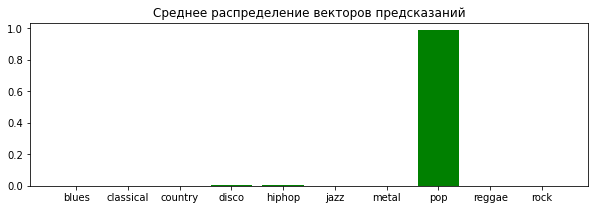

---------------------------------------------------------------
Файл: ./genres/pop/pop.00053.au
Векторы для предсказания: (1292, 37)
Классификация сети: pop - ВЕРНО :-)


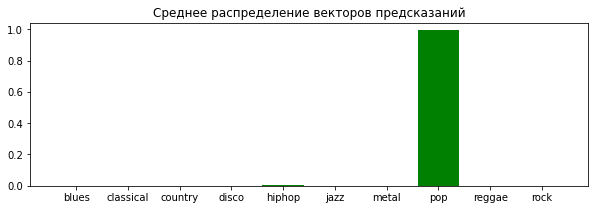

---------------------------------------------------------------
Файл: ./genres/pop/pop.00054.au
Векторы для предсказания: (1292, 37)
Классификация сети: pop - ВЕРНО :-)


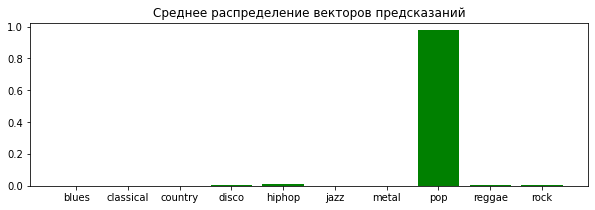

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00050.au
Векторы для предсказания: (1292, 37)
Классификация сети: reggae - ВЕРНО :-)


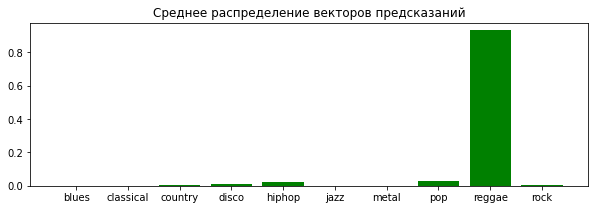

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00051.au
Векторы для предсказания: (1292, 37)
Классификация сети: reggae - ВЕРНО :-)


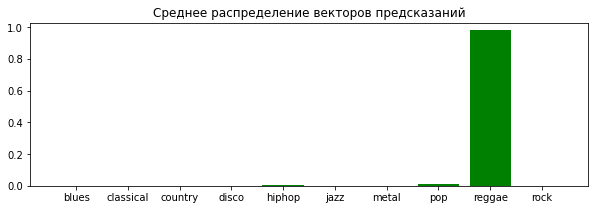

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00052.au
Векторы для предсказания: (1292, 37)
Классификация сети: reggae - ВЕРНО :-)


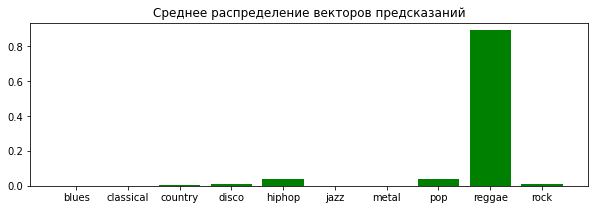

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00053.au
Векторы для предсказания: (1292, 37)
Классификация сети: reggae - ВЕРНО :-)


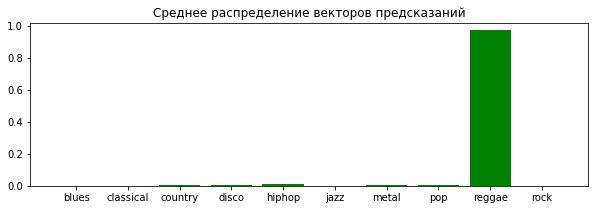

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00054.au
Векторы для предсказания: (1292, 37)
Классификация сети: reggae - ВЕРНО :-)


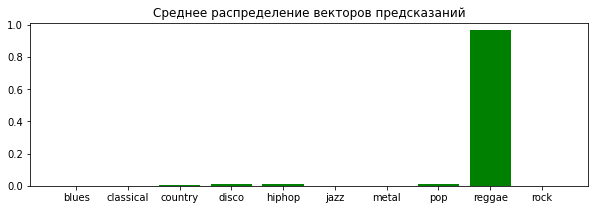

---------------------------------------------------------------
Файл: ./genres/rock/rock.00050.au
Векторы для предсказания: (1292, 37)
Классификация сети: rock - ВЕРНО :-)


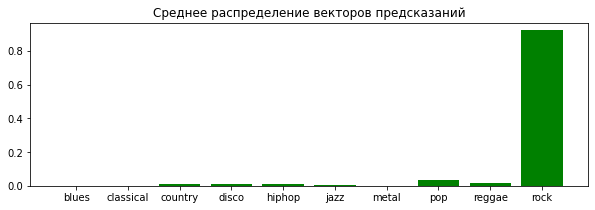

---------------------------------------------------------------
Файл: ./genres/rock/rock.00051.au
Векторы для предсказания: (1292, 37)
Классификация сети: rock - ВЕРНО :-)


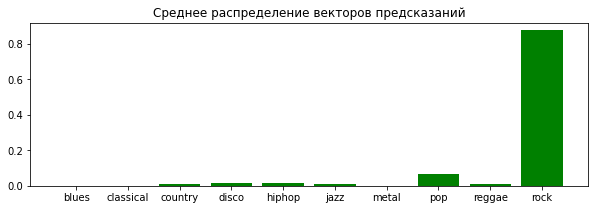

---------------------------------------------------------------
Файл: ./genres/rock/rock.00052.au
Векторы для предсказания: (1292, 37)
Классификация сети: rock - ВЕРНО :-)


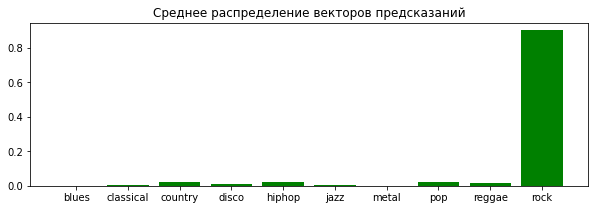

---------------------------------------------------------------
Файл: ./genres/rock/rock.00053.au
Векторы для предсказания: (1292, 37)
Классификация сети: rock - ВЕРНО :-)


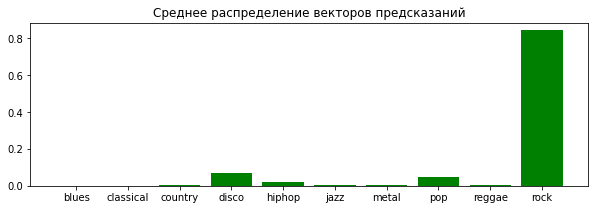

---------------------------------------------------------------
Файл: ./genres/rock/rock.00054.au
Векторы для предсказания: (1292, 37)
Классификация сети: rock - ВЕРНО :-)


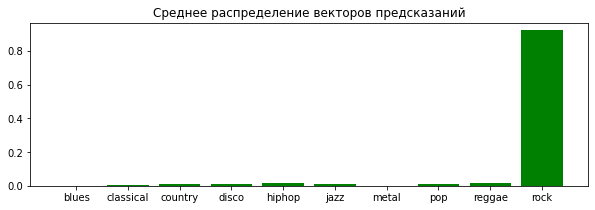

---------------------------------------------------------------
=== Обработано образцов: 50, из них распознано верно: 50, доля верных: 100.0% ===


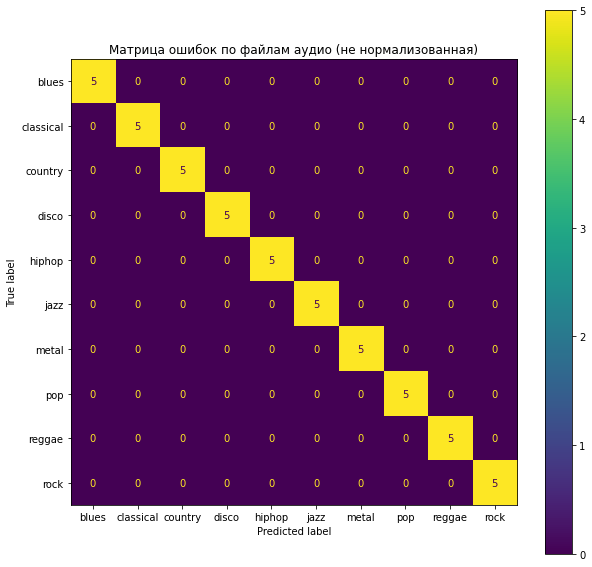

In [ ]:
# Визуализация классификации файлов из тренировочного набора
classify_test_files(model, x_scaler, 50, 5)

###Визуализация на файлах тестового набора

Файл: ./genres/blues/blues.00095.au
Векторы для предсказания: (1292, 37)
Классификация сети: blues - ВЕРНО :-)


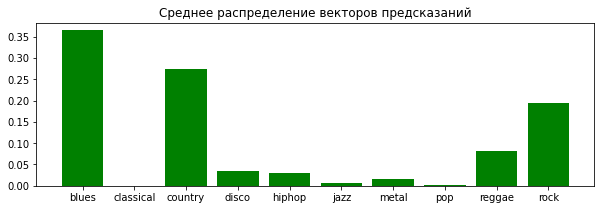

---------------------------------------------------------------
Файл: ./genres/blues/blues.00096.au
Векторы для предсказания: (1292, 37)
Классификация сети: country - НЕВЕРНО.


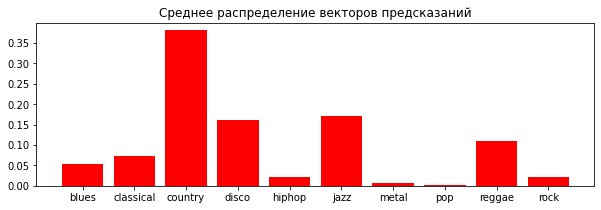

---------------------------------------------------------------
Файл: ./genres/blues/blues.00097.au
Векторы для предсказания: (1292, 37)
Классификация сети: blues - ВЕРНО :-)


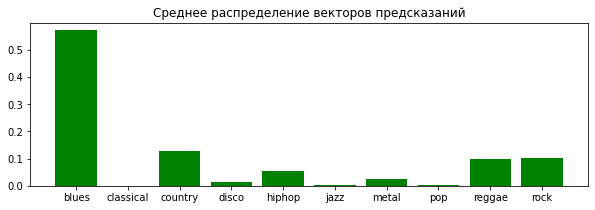

---------------------------------------------------------------
Файл: ./genres/blues/blues.00098.au
Векторы для предсказания: (1292, 37)
Классификация сети: rock - НЕВЕРНО.


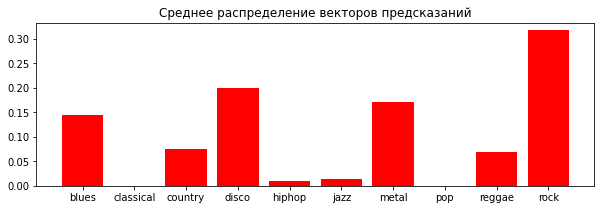

---------------------------------------------------------------
Файл: ./genres/blues/blues.00099.au
Векторы для предсказания: (1292, 37)
Классификация сети: country - НЕВЕРНО.


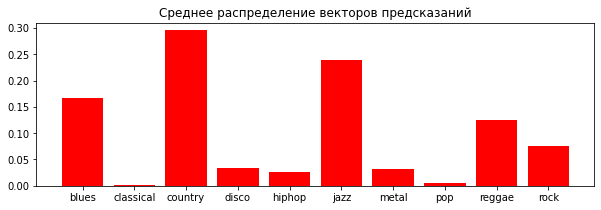

---------------------------------------------------------------
Файл: ./genres/classical/classical.00095.au
Векторы для предсказания: (1292, 37)
Классификация сети: classical - ВЕРНО :-)


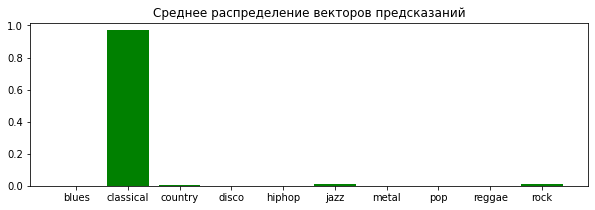

---------------------------------------------------------------
Файл: ./genres/classical/classical.00096.au
Векторы для предсказания: (1292, 37)
Классификация сети: classical - ВЕРНО :-)


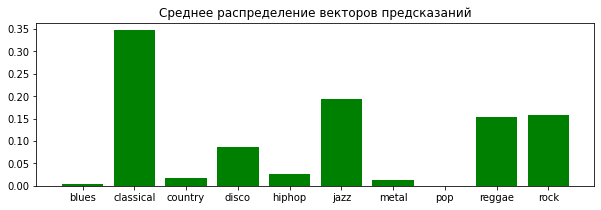

---------------------------------------------------------------
Файл: ./genres/classical/classical.00097.au
Векторы для предсказания: (1292, 37)
Классификация сети: classical - ВЕРНО :-)


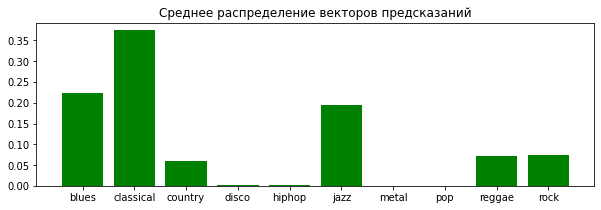

---------------------------------------------------------------
Файл: ./genres/classical/classical.00098.au
Векторы для предсказания: (1292, 37)
Классификация сети: classical - ВЕРНО :-)


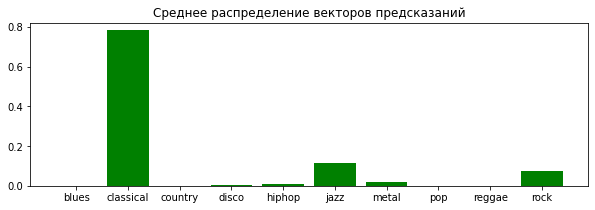

---------------------------------------------------------------
Файл: ./genres/classical/classical.00099.au
Векторы для предсказания: (1292, 37)
Классификация сети: classical - ВЕРНО :-)


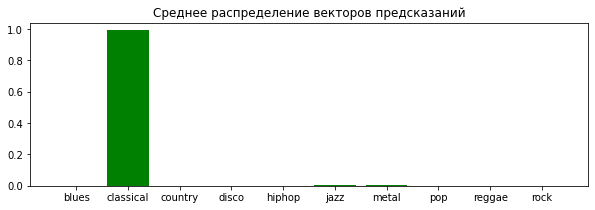

---------------------------------------------------------------
Файл: ./genres/country/country.00095.au
Векторы для предсказания: (1292, 37)
Классификация сети: blues - НЕВЕРНО.


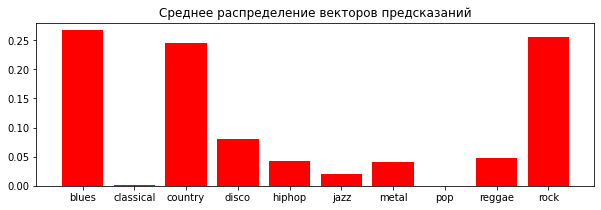

---------------------------------------------------------------
Файл: ./genres/country/country.00096.au
Векторы для предсказания: (1292, 37)
Классификация сети: country - ВЕРНО :-)


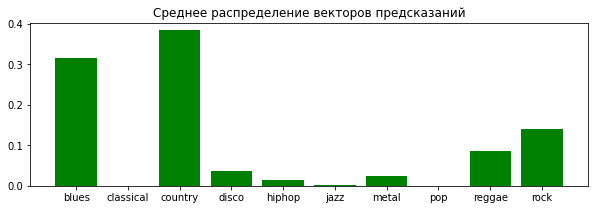

---------------------------------------------------------------
Файл: ./genres/country/country.00097.au
Векторы для предсказания: (1292, 37)
Классификация сети: country - ВЕРНО :-)


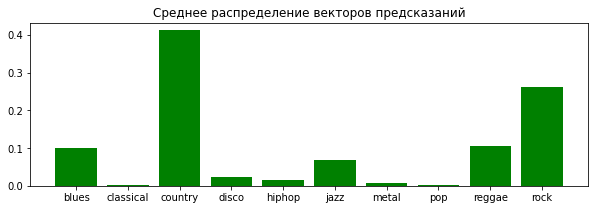

---------------------------------------------------------------
Файл: ./genres/country/country.00098.au
Векторы для предсказания: (1292, 37)
Классификация сети: blues - НЕВЕРНО.


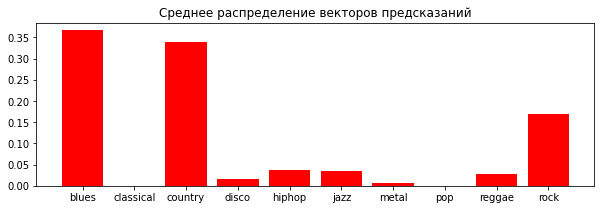

---------------------------------------------------------------
Файл: ./genres/country/country.00099.au
Векторы для предсказания: (1292, 37)
Классификация сети: country - ВЕРНО :-)


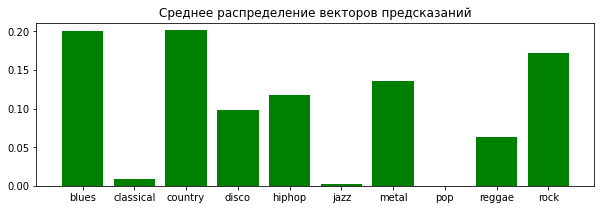

---------------------------------------------------------------
Файл: ./genres/disco/disco.00095.au
Векторы для предсказания: (1292, 37)
Классификация сети: disco - ВЕРНО :-)


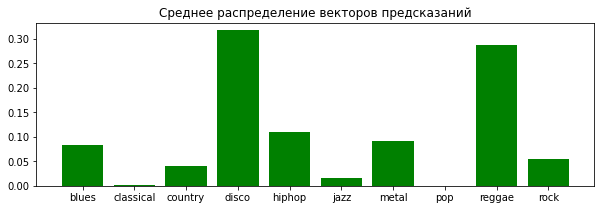

---------------------------------------------------------------
Файл: ./genres/disco/disco.00096.au
Векторы для предсказания: (1292, 37)
Классификация сети: rock - НЕВЕРНО.


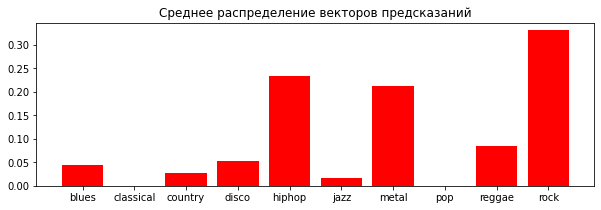

---------------------------------------------------------------
Файл: ./genres/disco/disco.00097.au
Векторы для предсказания: (1292, 37)
Классификация сети: blues - НЕВЕРНО.


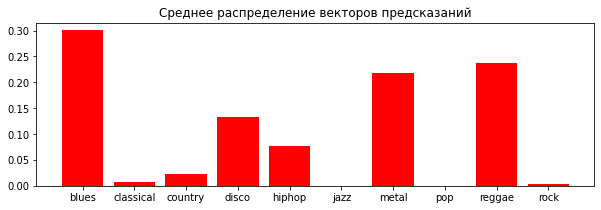

---------------------------------------------------------------
Файл: ./genres/disco/disco.00098.au
Векторы для предсказания: (1292, 37)
Классификация сети: rock - НЕВЕРНО.


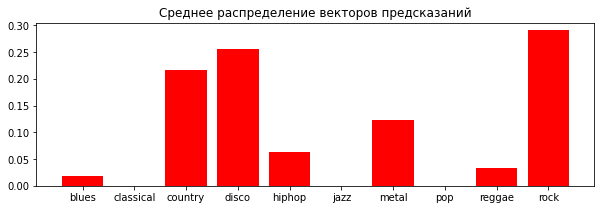

---------------------------------------------------------------
Файл: ./genres/disco/disco.00099.au
Векторы для предсказания: (1292, 37)
Классификация сети: rock - НЕВЕРНО.


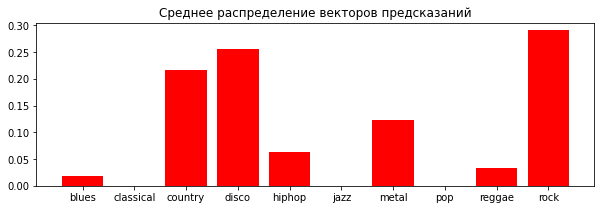

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00095.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - НЕВЕРНО.


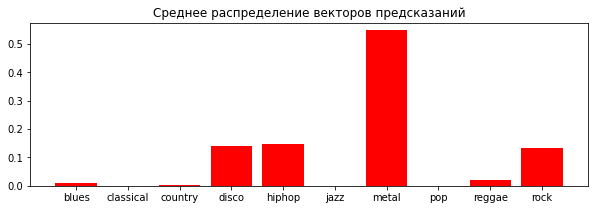

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00096.au
Векторы для предсказания: (1292, 37)
Классификация сети: rock - НЕВЕРНО.


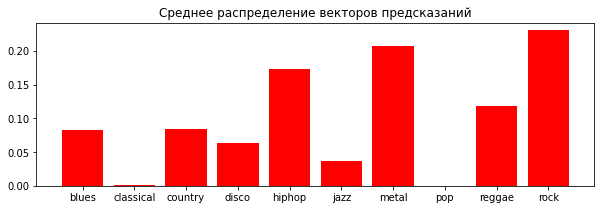

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00097.au
Векторы для предсказания: (1292, 37)
Классификация сети: hiphop - ВЕРНО :-)


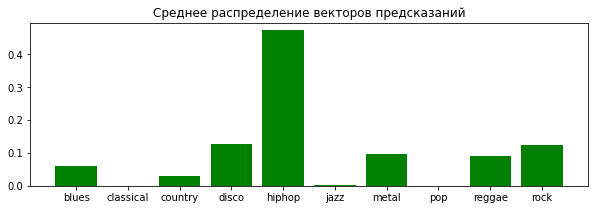

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00098.au
Векторы для предсказания: (1292, 37)
Классификация сети: hiphop - ВЕРНО :-)


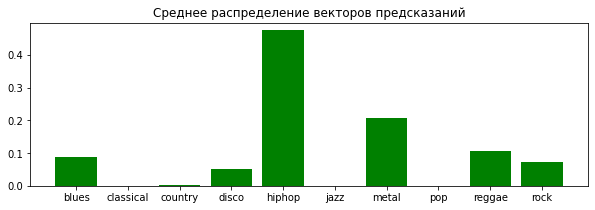

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00099.au
Векторы для предсказания: (1292, 37)
Классификация сети: hiphop - ВЕРНО :-)


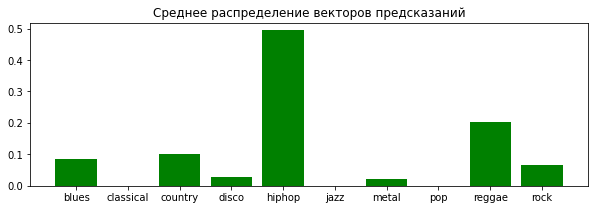

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00095.au
Векторы для предсказания: (1292, 37)
Классификация сети: jazz - ВЕРНО :-)


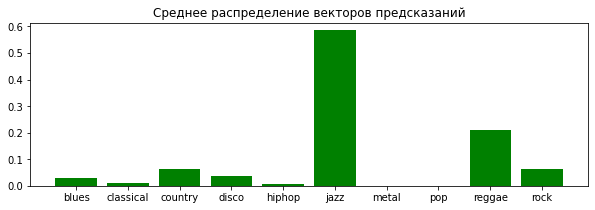

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00096.au
Векторы для предсказания: (1292, 37)
Классификация сети: jazz - ВЕРНО :-)


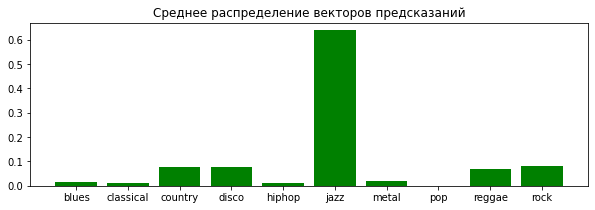

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00097.au
Векторы для предсказания: (1292, 37)
Классификация сети: jazz - ВЕРНО :-)


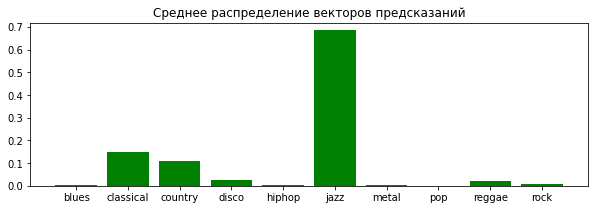

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00098.au
Векторы для предсказания: (1292, 37)
Классификация сети: jazz - ВЕРНО :-)


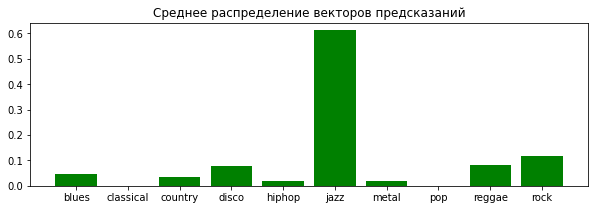

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00099.au
Векторы для предсказания: (1292, 37)
Классификация сети: jazz - ВЕРНО :-)


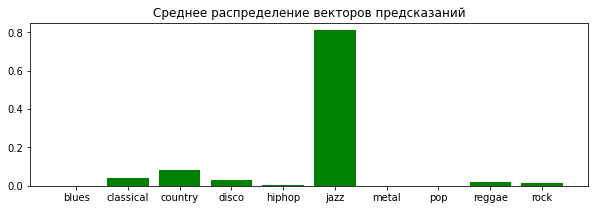

---------------------------------------------------------------
Файл: ./genres/metal/metal.00095.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - ВЕРНО :-)


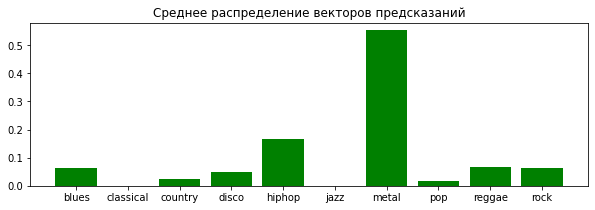

---------------------------------------------------------------
Файл: ./genres/metal/metal.00096.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - ВЕРНО :-)


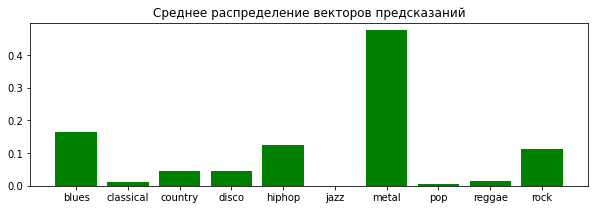

---------------------------------------------------------------
Файл: ./genres/metal/metal.00097.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - ВЕРНО :-)


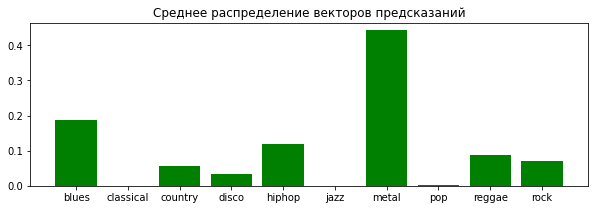

---------------------------------------------------------------
Файл: ./genres/metal/metal.00098.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - ВЕРНО :-)


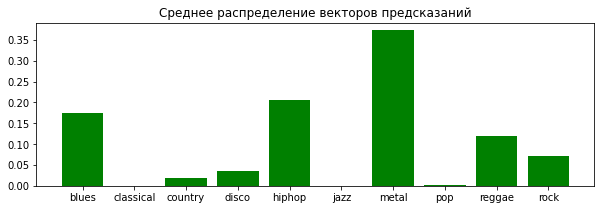

---------------------------------------------------------------
Файл: ./genres/metal/metal.00099.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - ВЕРНО :-)


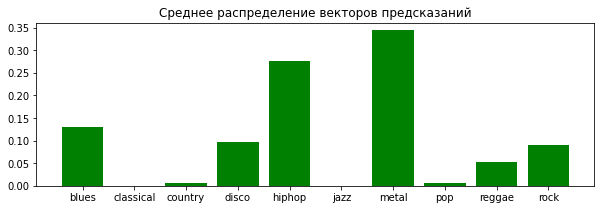

---------------------------------------------------------------
Файл: ./genres/pop/pop.00095.au
Векторы для предсказания: (1292, 37)
Классификация сети: pop - ВЕРНО :-)


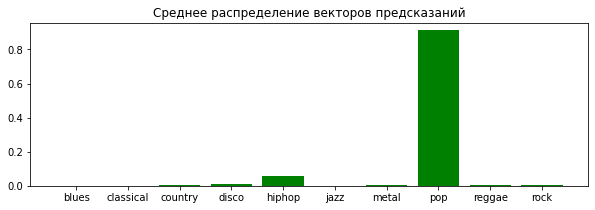

---------------------------------------------------------------
Файл: ./genres/pop/pop.00096.au
Векторы для предсказания: (1292, 37)
Классификация сети: pop - ВЕРНО :-)


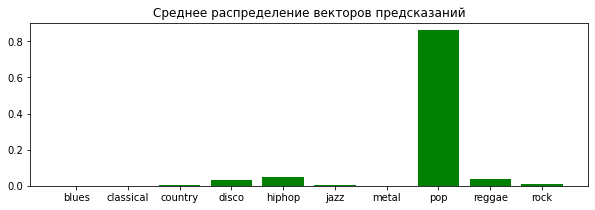

---------------------------------------------------------------
Файл: ./genres/pop/pop.00097.au
Векторы для предсказания: (1292, 37)
Классификация сети: pop - ВЕРНО :-)


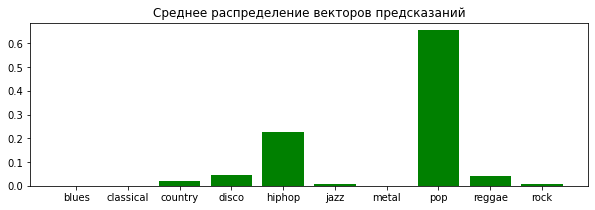

---------------------------------------------------------------
Файл: ./genres/pop/pop.00098.au
Векторы для предсказания: (1292, 37)
Классификация сети: pop - ВЕРНО :-)


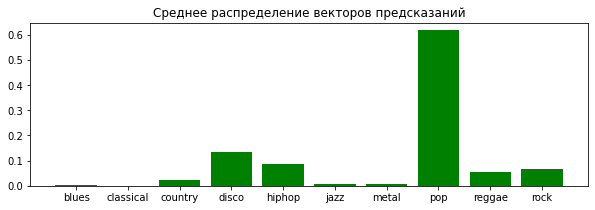

---------------------------------------------------------------
Файл: ./genres/pop/pop.00099.au
Векторы для предсказания: (1292, 37)
Классификация сети: pop - ВЕРНО :-)


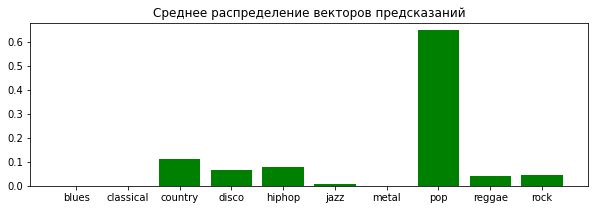

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00095.au
Векторы для предсказания: (1292, 37)
Классификация сети: hiphop - НЕВЕРНО.


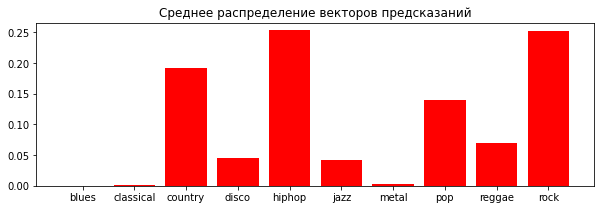

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00096.au
Векторы для предсказания: (1292, 37)
Классификация сети: reggae - ВЕРНО :-)


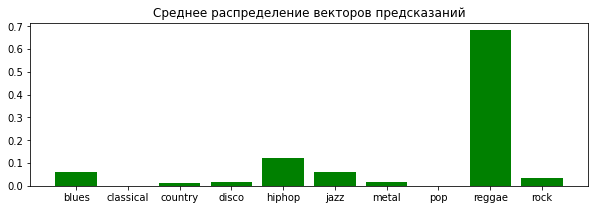

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00097.au
Векторы для предсказания: (1292, 37)
Классификация сети: country - НЕВЕРНО.


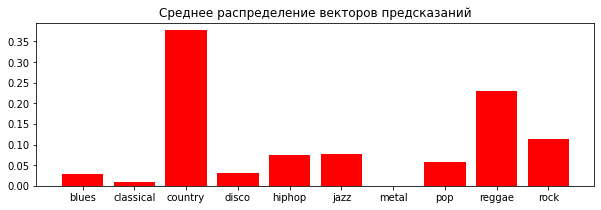

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00098.au
Векторы для предсказания: (1292, 37)
Классификация сети: reggae - ВЕРНО :-)


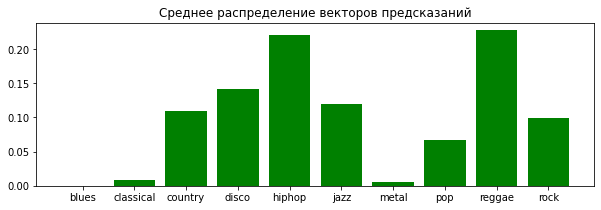

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00099.au
Векторы для предсказания: (1292, 37)
Классификация сети: hiphop - НЕВЕРНО.


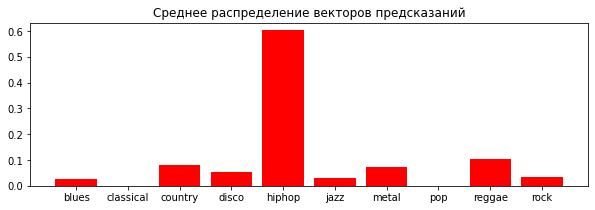

---------------------------------------------------------------
Файл: ./genres/rock/rock.00095.au
Векторы для предсказания: (1292, 37)
Классификация сети: rock - ВЕРНО :-)


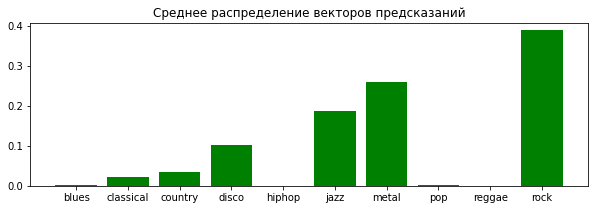

---------------------------------------------------------------
Файл: ./genres/rock/rock.00096.au
Векторы для предсказания: (1292, 37)
Классификация сети: rock - ВЕРНО :-)


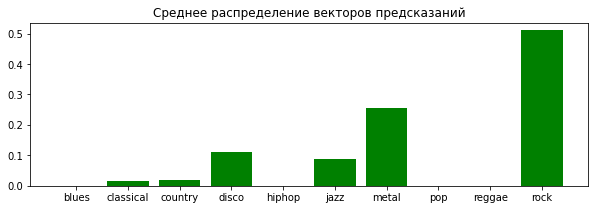

---------------------------------------------------------------
Файл: ./genres/rock/rock.00097.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - НЕВЕРНО.


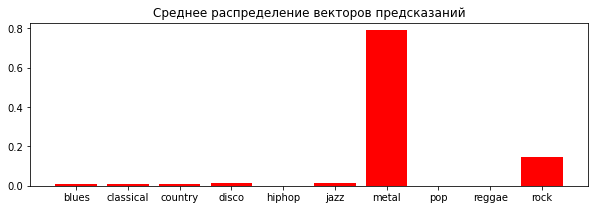

---------------------------------------------------------------
Файл: ./genres/rock/rock.00098.au
Векторы для предсказания: (1292, 37)
Классификация сети: country - НЕВЕРНО.


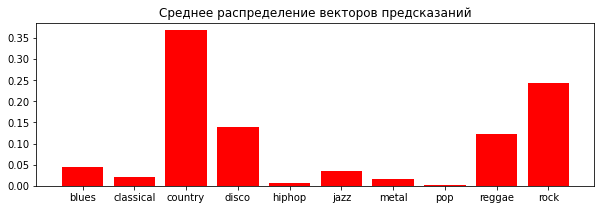

---------------------------------------------------------------
Файл: ./genres/rock/rock.00099.au
Векторы для предсказания: (1292, 37)
Классификация сети: metal - НЕВЕРНО.


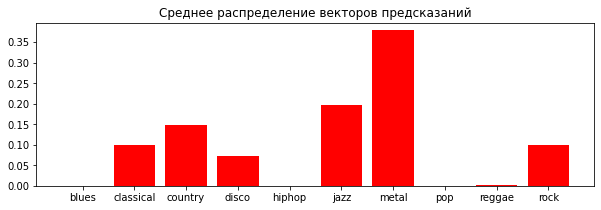

---------------------------------------------------------------
=== Обработано образцов: 50, из них распознано верно: 33, доля верных: 66.0% ===


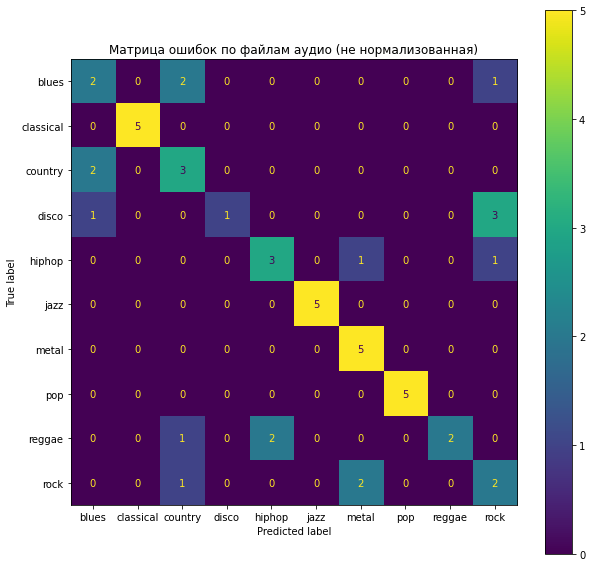

In [ ]:
# Визуализация классификации файлов из тестового набора
classify_test_files(model, x_scaler, 95, 5)

**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1RaiYPz-2sS-EReNQL7tW6ms8ZuZphJLS?usp=sharing)

2. [Практика 1](https://colab.research.google.com/drive/1rd5i7URs1v_P8-KveFGFAQJ9thayJk1c?usp=sharing)

3. [Практика 2](https://colab.research.google.com/drive/1CSKLkE5eg6Y05o2pQigXH1wgZ0xqbXAw?usp=sharing)

4. Практика 3